$$Airbnb: \space New \space User \space Bookings $$

# `01` Importing Necessary Libraries

In [1]:
# Filter out warnings for cleaner outputs
import warnings
warnings.filterwarnings('ignore')

## `i` Data Manipulation Libraries

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mode, randint
from scipy.sparse import hstack
import re
pd.set_option('display.max_columns', None)

## `ii` Visualization Libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
plt.rcParams["figure.dpi"] = 120

## `ii` Preprocessing Libraries

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

## `iii` Model Libraries

In [5]:
# sklearn
import sklearn

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Evaluation
from sklearn.metrics import make_scorer

----------------

# `02` Loading Data

In [6]:
user_data = pd.read_csv("/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip", parse_dates=["date_account_created", "date_first_booking", "timestamp_first_active"])
countries_data = pd.read_csv("/kaggle/input/airbnb-recruiting-new-user-bookings/countries.csv.zip")
sessions_data = pd.read_csv("/kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip")
age_gender_data = pd.read_csv("/kaggle/input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip")
test_data = pd.read_csv("/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip", parse_dates=["date_account_created", "timestamp_first_active"])

In [7]:
datasets = [('Users', user_data), ('Countries', countries_data), ('Sessions', sessions_data), ('Age Gender Buckets', age_gender_data)]

----------------

# `03` Exploratory Data Analysis (EDA)

## `i` Data Preview

In [8]:
user_data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [9]:
countries_data.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [10]:
sessions_data.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [11]:
age_gender_data.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


## `ii` Columns Data Types

In [12]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       213451 non-null  object        
 1   date_account_created     213451 non-null  datetime64[ns]
 2   timestamp_first_active   213451 non-null  datetime64[ns]
 3   date_first_booking       88908 non-null   datetime64[ns]
 4   gender                   213451 non-null  object        
 5   age                      125461 non-null  float64       
 6   signup_method            213451 non-null  object        
 7   signup_flow              213451 non-null  int64         
 8   language                 213451 non-null  object        
 9   affiliate_channel        213451 non-null  object        
 10  affiliate_provider       213451 non-null  object        
 11  first_affiliate_tracked  207386 non-null  object        
 12  signup_app      

In [13]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       62096 non-null  object        
 1   date_account_created     62096 non-null  datetime64[ns]
 2   timestamp_first_active   62096 non-null  datetime64[ns]
 3   date_first_booking       0 non-null      float64       
 4   gender                   62096 non-null  object        
 5   age                      33220 non-null  float64       
 6   signup_method            62096 non-null  object        
 7   signup_flow              62096 non-null  int64         
 8   language                 62096 non-null  object        
 9   affiliate_channel        62096 non-null  object        
 10  affiliate_provider       62096 non-null  object        
 11  first_affiliate_tracked  62076 non-null  object        
 12  signup_app               62096 n

In [14]:
countries_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country_destination            10 non-null     object 
 1   lat_destination                10 non-null     float64
 2   lng_destination                10 non-null     float64
 3   distance_km                    10 non-null     float64
 4   destination_km2                10 non-null     float64
 5   destination_language           10 non-null     object 
 6   language_levenshtein_distance  10 non-null     float64
dtypes: float64(5), object(2)
memory usage: 688.0+ bytes


In [15]:
sessions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [16]:
age_gender_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_bucket               420 non-null    object 
 1   country_destination      420 non-null    object 
 2   gender                   420 non-null    object 
 3   population_in_thousands  420 non-null    float64
 4   year                     420 non-null    float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


## `iii` Descriptive Statistics

### `age` Column

In [17]:
user_data.age.describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

*Notes:*
- Something is not right with the values of the `age` column.
- There seems to be impossible values such as "2014" that might be a handling error or invalid user input.
- Usually, capping can be used to eliminate such outlier values.

### Categorical Columns in `user_data`

In [18]:
for col in user_data.select_dtypes("object").columns:
    if len(user_data[col].unique()) < 26:
        print("-"*25, f"\n{col} Column\n", "-"*25)
        display(user_data[col].value_counts())
    elif col != 'id':
        print("-"*25, f"\n{col} Column (Top 10)\n", "-"*25)
        display(user_data[col].value_counts()[:10])

------------------------- 
gender Column
 -------------------------


-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64

------------------------- 
signup_method Column
 -------------------------


basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64

------------------------- 
language Column
 -------------------------


en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
el        24
th        24
id        22
hu        18
fi        14
ca         5
is         5
hr         2
Name: language, dtype: int64

------------------------- 
affiliate_channel Column
 -------------------------


direct           137727
sem-brand         26045
sem-non-brand     18844
other              8961
seo                8663
api                8167
content            3948
remarketing        1096
Name: affiliate_channel, dtype: int64

------------------------- 
affiliate_provider Column
 -------------------------


direct                 137426
google                  51693
other                   12549
craigslist               3471
bing                     2328
facebook                 2273
vast                      829
padmapper                 768
facebook-open-graph       545
yahoo                     496
gsp                       453
meetup                    347
email-marketing           166
naver                      52
baidu                      29
yandex                     17
wayn                        8
daum                        1
Name: affiliate_provider, dtype: int64

------------------------- 
first_affiliate_tracked Column
 -------------------------


untracked        109232
linked            46287
omg               43982
tracked-other      6156
product            1556
marketing           139
local ops            34
Name: first_affiliate_tracked, dtype: int64

------------------------- 
signup_app Column
 -------------------------


Web        182717
iOS         19019
Moweb        6261
Android      5454
Name: signup_app, dtype: int64

------------------------- 
first_device_type Column
 -------------------------


Mac Desktop           89600
Windows Desktop       72716
iPhone                20759
iPad                  14339
Other/Unknown         10667
Android Phone          2803
Android Tablet         1292
Desktop (Other)        1199
SmartPhone (Other)       76
Name: first_device_type, dtype: int64

------------------------- 
first_browser Column (Top 10)
 -------------------------


Chrome             63845
Safari             45169
Firefox            33655
-unknown-          27266
IE                 21068
Mobile Safari      19274
Chrome Mobile       1270
Android Browser      851
AOL Explorer         245
Opera                188
Name: first_browser, dtype: int64

------------------------- 
country_destination Column
 -------------------------


NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

*Notes:*
- Gender `-unknown-` value should be treated as NaN.
- First_browser `-unknown-` value should be treated as NaN.

### Categorical Columns in `sessions_data`

In [19]:
for col in sessions_data.select_dtypes("object").columns:
    if len(sessions_data[col].unique()) < 15:
        print("-"*25, f"\n{col} Column\n", "-"*25)
        display(sessions_data[col].value_counts())
    else:
        print("-"*25, f"\n{col} Column (Top 15)\n", "-"*25)
        display(sessions_data[col].value_counts()[:15])

------------------------- 
user_id Column (Top 15)
 -------------------------


mxqbh3ykxl    2722
0hjoc5q8nf    2644
mjbl6rrj52    2476
l5lgm3w5pc    2424
wg9413iaux    2362
ht8alhs4lt    2335
wyv1imf8qw    2323
9z4gim1s4l    2264
monrpvx2md    2264
h0cjxc177k    2246
a0uhiojrra    2137
vcmr2jh5ix    2085
1m6xnhstmb    2019
p1183hxzc4    1938
e8h4qghxlg    1923
Name: user_id, dtype: int64

------------------------- 
action Column (Top 15)
 -------------------------


show                     2768278
index                     843699
search_results            725226
personalize               706824
search                    536057
ajax_refresh_subtotal     487744
update                    365130
similar_listings          364624
social_connections        339000
reviews                   320591
active                    188036
similar_listings_v2       168788
lookup                    162041
create                    155887
dashboard                 152952
Name: action, dtype: int64

------------------------- 
action_type Column
 -------------------------


view                3560902
data                2103770
click               1996183
-unknown-           1031170
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64

------------------------- 
action_detail Column (Top 15)
 -------------------------


view_search_results            1776885
p3                             1376550
-unknown-                      1031141
wishlist_content_update         706824
user_profile                    656839
change_trip_characteristics     487744
similar_listings                364624
user_social_connections         336799
update_listing                  269779
listing_reviews                 269021
dashboard                       152952
user_wishlists                  152672
header_userpic                  141830
message_thread                  132395
edit_profile                    108686
Name: action_detail, dtype: int64

------------------------- 
device_type Column
 -------------------------


Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
-unknown-                            211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

*Notes:*
- Action_type `-unknown-` value should be treated as NaN.
- Action_detail `-unknown-` value should be treated as NaN.
- Device_type `-unknown-` value should be treated as NaN.

### Date Columns in `user_data`

In [20]:
print("-"*10, "Interval between First Activity Date and Account Creation Date", "-"*10)
(user_data.date_account_created - user_data.timestamp_first_active).describe()

---------- Interval between First Activity Date and Account Creation Date ----------


count                         213451
mean     -1 days +16:49:13.629563694
std       11 days 22:51:00.251023529
min                -1 days +00:00:01
25%                -1 days +03:50:59
50%                -1 days +08:17:20
75%                -1 days +19:21:36
max               1455 days 09:53:18
dtype: object

In [21]:
print("-"*10, "Interval between First Activity Date and First Booking Date", "-"*10)
(user_data.date_first_booking - user_data.timestamp_first_active).describe()

---------- Interval between First Activity Date and First Booking Date ----------


count                         88908
mean     44 days 03:51:50.874656950
std      88 days 11:28:55.261149382
min               -1 days +00:01:17
25%                 0 days 00:26:18
50%                 2 days 05:52:44
75%         28 days 22:52:50.750000
max              1368 days 06:33:01
dtype: object

In [22]:
print("-"*10, "Interval between Account Creation Date and First Booking Date", "-"*10)
(user_data.date_first_booking - user_data.date_account_created).describe()

---------- Interval between Account Creation Date and First Booking Date ----------


count                         88908
mean     44 days 08:41:59.854231340
std      87 days 11:59:22.090141649
min             -349 days +00:00:00
25%                 1 days 00:00:00
50%                 3 days 00:00:00
75%                29 days 00:00:00
max               365 days 00:00:00
dtype: object

## `iv` Duplicate Rows

In [23]:
for name, dataset in datasets:
    print(f"{name} Dataset Duplicate Rows: {dataset.duplicated().sum():,}")

Users Dataset Duplicate Rows: 0
Countries Dataset Duplicate Rows: 0
Sessions Dataset Duplicate Rows: 252,536
Age Gender Buckets Dataset Duplicate Rows: 0


In [24]:
sessions_data[sessions_data.duplicated(keep=False)].head(20)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
420,qtw88d9pbl,show,NaN,NaN,Mac Desktop,180.0
430,qtw88d9pbl,show,NaN,NaN,Mac Desktop,180.0
520,qtw88d9pbl,show,NaN,NaN,Mac Desktop,94.0
522,qtw88d9pbl,show,view,p3,Mac Desktop,2333.0
585,qtw88d9pbl,similar_listings,data,similar_listings,Mac Desktop,193.0
587,qtw88d9pbl,show,NaN,NaN,Mac Desktop,149.0
605,qtw88d9pbl,show,NaN,NaN,Mac Desktop,149.0
645,qtw88d9pbl,similar_listings,data,similar_listings,Mac Desktop,193.0
659,qtw88d9pbl,show,NaN,NaN,Mac Desktop,94.0
689,qtw88d9pbl,lookup,NaN,NaN,Mac Desktop,58.0


*Notes:*
- It seems we have more than a few duplicates in the `sessions` dataset.
- We should drop these duplicate rows since they are redundant.

## `v` Null Values Percentage (%)

In [25]:
for name, dataset in datasets:
    print(f"---------------------------------------------\n{name} Dataset [Total Records: {dataset.shape[0]:,}]\n---------------------------------------------")
    nulls = round((dataset.isnull().sum(axis=0)/dataset.shape[0])*100, 2)
    display(nulls[nulls > 0].sort_values(ascending=False))

---------------------------------------------
Users Dataset [Total Records: 213,451]
---------------------------------------------


date_first_booking         58.35
age                        41.22
first_affiliate_tracked     2.84
dtype: float64

---------------------------------------------
Countries Dataset [Total Records: 10]
---------------------------------------------


Series([], dtype: float64)

---------------------------------------------
Sessions Dataset [Total Records: 10,567,737]
---------------------------------------------


action_type      10.66
action_detail    10.66
secs_elapsed      1.29
action            0.75
user_id           0.33
dtype: float64

---------------------------------------------
Age Gender Buckets Dataset [Total Records: 420]
---------------------------------------------


Series([], dtype: float64)

*Notes:*
- `Users` dataset:
    - 58% of the records in the `date_first_booking` column seem to be null. We can safely drop this column since it doesn't exist in the test dataset.
    - `Age` column also has a lot of null values. We might have to fill with one of the central tendency measures.
- `Sessions` dataset:
    - Both `action_type` and `action_detail` columns have about 10.66% null values. Depending on the feature engineering and/or selection later, this percentage might not prove critical to the model performance.

----------------

# `04` Data Preprocessing

## `i` Handling `-unknown-` Values

In [26]:
# Function to ease handling these values in the test dataset later
def handle_unknown(df):
    """Reduce values '-unknown-' in both gender and first_browser columns to np.nan"""
    print(f"Operation affected {df.loc[df[df['gender'] == '-unknown-'].index].shape[0]:,} records in the gender column.")
    df.loc[df[df['gender'] == '-unknown-'].index, 'gender'] = np.nan
    display(df['gender'].value_counts(dropna=False))
    
    print(f"\nOperation affected {df.loc[df[df['first_browser'] == '-unknown-'].index].shape[0]:,} records in the first_browser column.")
    df.loc[df[df['first_browser'] == '-unknown-'].index, 'first_browser'] = np.nan
    display(df['first_browser'].value_counts(dropna=False))

In [27]:
# gender and first_browser column in user_data dataset
handle_unknown(user_data)

Operation affected 95,688 records in the gender column.


NaN       95688
FEMALE    63041
MALE      54440
OTHER       282
Name: gender, dtype: int64


Operation affected 27,266 records in the first_browser column.


Chrome                  63845
Safari                  45169
Firefox                 33655
NaN                     27266
IE                      21068
Mobile Safari           19274
Chrome Mobile            1270
Android Browser           851
AOL Explorer              245
Opera                     188
Silk                      124
Chromium                   73
BlackBerry Browser         53
Maxthon                    46
IE Mobile                  36
Apple Mail                 36
Sogou Explorer             33
Mobile Firefox             30
SiteKiosk                  24
RockMelt                   24
Iron                       17
IceWeasel                  13
Pale Moon                  12
SeaMonkey                  11
CometBird                  11
Yandex.Browser             11
Camino                      9
TenFourFox                  8
CoolNovo                    6
wOSBrowser                  6
Avant Browser               4
Opera Mini                  4
Mozilla                     3
TheWorld B

In [28]:
# action_type column in sessions_data dataset
print(f"Operation affected {sessions_data.loc[sessions_data[sessions_data['action_type'] == '-unknown-'].index].shape[0]:,} records in the action_type column.")
sessions_data.loc[sessions_data[sessions_data['action_type'] == '-unknown-'].index, 'action_type'] = np.nan
display(sessions_data['action_type'].value_counts(dropna=False))

Operation affected 1,031,170 records in the action_type column.


view                3560902
NaN                 2157374
data                2103770
click               1996183
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64

In [29]:
# action_detail column in sessions_data dataset
print(f"Operation affected {sessions_data.loc[sessions_data[sessions_data['action_detail'] == '-unknown-'].index].shape[0]:,} records in the action_detail column.")
sessions_data.loc[sessions_data[sessions_data['action_detail'] == '-unknown-'].index, 'action_detail'] = np.nan
display(sessions_data['action_detail'].value_counts(dropna=False))

Operation affected 1,031,141 records in the action_detail column.


NaN                         2157345
view_search_results         1776885
p3                          1376550
wishlist_content_update      706824
user_profile                 656839
                             ...   
special_offer_field               3
tos_2014                          2
host_refund_guest                 2
host_respond_page                 2
host_standard_suspension          1
Name: action_detail, Length: 155, dtype: int64

In [30]:
# device_type column in sessions_data dataset
print(f"Operation affected {sessions_data.loc[sessions_data[sessions_data['device_type'] == '-unknown-'].index].shape[0]:,} records in the device_type column.")
sessions_data.loc[sessions_data[sessions_data['device_type'] == '-unknown-'].index, 'device_type'] = np.nan
display(sessions_data['device_type'].value_counts(dropna=False))

Operation affected 211,279 records in the device_type column.


Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
NaN                                  211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

## `ii` Dropping Duplicate Rows

In [31]:
print(f"Operation affected {sessions_data.duplicated().sum():,} records in the sessions dataset.\nRecords before dropping duplicates: {sessions_data.shape[0]:,}")
sessions_data.drop_duplicates(inplace=True)
print(f"Records after dropping duplicates: {sessions_data.shape[0]:,}")

Operation affected 252,730 records in the sessions dataset.
Records before dropping duplicates: 10,567,737
Records after dropping duplicates: 10,315,007


## `iii` Handling Outlier Values

In [32]:
# Functions to ease the test data processing later

def calc_age_from_bdate(df, LB=1900, UB=2000):
    """Calculate the age by subtracting the presumed birth date from the account creation date"""
    bdate_index = df[np.logical_and(df['age'] > LB, df['age'] < UB)]['age'].index
    print(f"Operation affected {df.loc[bdate_index].shape[0]:,} records.")
    df.loc[bdate_index, 'age'] = (df.loc[bdate_index]['date_account_created'].dt.year - df.loc[bdate_index]['age'])
    
    
def nullify_age_outliers(df, LB=18, UB=120):
    """Reduce records containing age values outside the interval [LB, UB] exclusive to np.nan."""
    print(f"Upperbound Operation affected {df.loc[df[df['age'] > UB].index].shape[0]:,} records.")
    df.loc[df[df['age'] > UB].index, 'age'] = np.nan
    
    print(f"Lowerbound Operation affected {df.loc[df[df['age'] < LB].index].shape[0]:,} records.")
    df.loc[df[df['age'] < LB].index, 'age'] = np.nan

In [33]:
print("-"*6, "Records with above normal age values", "-"*6)
user_data[user_data['age'] > 120]['age'].describe()

------ Records with above normal age values ------


count     781.000000
mean     2006.308579
std        95.711349
min       132.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

In [34]:
print("-"*6, "Records with age values below legal age", "-"*6)
user_data[user_data['age'] < 18]['age'].describe()

------ Records with age values below legal age ------


count    158.000000
mean      12.202532
std        5.916359
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

In [35]:
user_data[user_data['age'] > 120]['age'].unique()

array([2014., 2013., 1949., 1931., 1932., 1928., 1936., 1933., 1935.,
       1925., 1952.,  150., 1927.,  132., 1953., 1942., 1995., 2008.,
       1924., 1929., 1947., 1938., 1926.])

*Notes:*
- Values larger than 120 is not correct; since the longest documented lifespan was 122. Those can be reduced to `np.nan`.
- Values $\in [1924, 1995]$ can be considered birthdates. We can calculate the age at account creation date.
- Values larger than 2000 can be reduced tp `np.nan`. Since they won't be a reasonable birthdate at that time.
- Values smaller than 18 can be reduced to np.nan since the Airbnb terms and condistions state legal age is a requirement for account creation.

In [36]:
# Calculate the age by subtracting the presumed birth date from the account creation date 

calc_age_from_bdate(user_data)

Operation affected 29 records.


In [37]:
# Reduce records containing age values outside the interval [18, 120] exclusive to np.nan

nullify_age_outliers(user_data)

Upperbound Operation affected 752 records.
Lowerbound Operation affected 158 records.


In [38]:
user_data[np.logical_or(user_data['age'] < 18, user_data['age'] > 120)]['age'].unique()

array([], dtype=float64)

## `iv` Handling Null Values

In [39]:
# Functions to ease test data processing later
def fill_age_nulls(df):
    """Fill the null values in both age column.
    \nMust set the Constant MEDIAN_AGE before using the function."""
    
    print(f"Operation affected {df.isna().sum().age:,} records in the users dataset.")
    df.age.fillna(MEDIAN_AGE, inplace=True)
    
    
def fill_fat_nulls(df):
    """Fill the null values in first_affiliate_tracked column.
    \nMust set the Constant FIRST_AFFILIATE_TRACKED before using the function."""
    
    print(f"Operation affected {df.isna().sum().first_affiliate_tracked:,} records in the users dataset.")
    df.first_affiliate_tracked.fillna(FIRST_AFFILIATE_TRACKED, inplace=True)

In [40]:
# Updated null values percentage 
(user_data.isna().sum() / user_data.shape[0])[user_data.isna().sum() > 0]

date_first_booking         0.583473
gender                     0.448290
age                        0.416489
first_affiliate_tracked    0.028414
first_browser              0.127739
dtype: float64

In [41]:
# Creating a copy to keep the original dataframe without filling the nulls
user_filled = user_data.copy()

In [42]:
# Age Column (Imputing with Central Tendency Measure)
# The median could be better since the age distribution is skewed
MEDIAN_AGE = user_data.age.median()

fill_age_nulls(user_filled)

Operation affected 88,900 records in the users dataset.


In [43]:
# First Affiliate Tracked Column (Imputing with 'untracked')
# Since it makes since from the business point of view
FIRST_AFFILIATE_TRACKED = 'untracked'

fill_fat_nulls(user_filled)

Operation affected 6,065 records in the users dataset.


In [44]:
# Sesc Elapsed Column (Imputing with Zero)

sessions_data.secs_elapsed.fillna(0, inplace=True)

*Notes:*
- We don't have to worry about the `date_first_booking` since it doesn't exist in the test dataset and will be dropped later.
- I will try to leave the rest of the columns containing null values as they are for now; since tree-based models are somewhat robust in that aspect.

## `v` Splitting Dates to Year, Month, Day Columns

In [45]:
def split_dates(df, drop_original=False, verbose=True):
    """Splits any column with dtype of datetime64[ns] into 3 columns namely _year, _month, _day.
        Keeps the original column if drop_original is not True"""
    date_cols = df.select_dtypes('datetime64[ns]').columns
    if len(date_cols) == 0:
        print("No columns with dtype of datetime[ns]!")
        return None
    for date_col in date_cols:
        if verbose:
            print(f"Splitting {date_col} Column...")
        df[date_col+'_year'] = df[date_col].dt.year
        df[date_col+'_month'] = df[date_col].dt.month
        df[date_col+'_day'] = df[date_col].dt.day
    if drop_original:
        df.drop(date_cols, axis=1, inplace=True)

In [46]:
# Extract year, month, day data from date columns keeping the original columns for visual analysis

split_dates(user_data)
split_dates(user_filled, verbose=False)

Splitting date_account_created Column...
Splitting timestamp_first_active Column...
Splitting date_first_booking Column...


## `vi` Grouping Minor Browsers in `first_browser` Column

In [47]:
def group_browsers(df, verbose=True):
    """Groups minor browsers that appear infrequently. Output two new categories Mobile and Others"""
    minors = df.first_browser.value_counts().index[np.where((df.first_browser.value_counts() < 500) == True)]
    mobile = []
    others = []
    for browser in minors:
        if 'Mobile' in browser:
            mobile.append(browser)
            df.first_browser.replace(to_replace=browser, value='Other Mobile', inplace=True)
        else:
            others.append(browser)
            df.first_browser.replace(to_replace=browser, value='Others', inplace=True)
    if verbose:
        print("Mobile Browsers Grouped: ", mobile)
        print("Other Browsers Grouped: ", others)

In [48]:
group_browsers(user_data)
group_browsers(user_filled, False)

Mobile Browsers Grouped:  ['IE Mobile', 'Mobile Firefox', 'Opera Mobile']
Other Browsers Grouped:  ['AOL Explorer', 'Opera', 'Silk', 'Chromium', 'BlackBerry Browser', 'Maxthon', 'Apple Mail', 'Sogou Explorer', 'SiteKiosk', 'RockMelt', 'Iron', 'IceWeasel', 'Pale Moon', 'SeaMonkey', 'CometBird', 'Yandex.Browser', 'Camino', 'TenFourFox', 'CoolNovo', 'wOSBrowser', 'Avant Browser', 'Opera Mini', 'Mozilla', 'TheWorld Browser', 'Flock', 'Comodo Dragon', 'OmniWeb', 'SlimBrowser', 'Crazy Browser', 'Epic', 'Stainless', 'Googlebot', 'Outlook 2007', 'Arora', 'NetNewsWire', 'PS Vita browser', 'Google Earth', 'Conkeror', 'Kindle Browser', 'Palm Pre web browser', 'IceDragon']


In [49]:
user_data.first_browser.value_counts()

Chrome             63845
Safari             45169
Firefox            33655
IE                 21068
Mobile Safari      19274
Chrome Mobile       1270
Others               985
Android Browser      851
Other Mobile          68
Name: first_browser, dtype: int64

## `vii` Grouping `session` Dataset by `user_id` and Applying TF-IDF

In [50]:
# Grouping by user_id and aggregating to a list except for secs_elapsed where sum is used
enlist = lambda x: x.to_list()
agg_methods = {'secs_elapsed': 'sum', 'action': enlist, 'action_type': enlist, 'action_detail': enlist, 'device_type': enlist}
grouped_sessions = sessions_data.groupby('user_id').agg(agg_methods)

In [51]:
grouped_sessions.head()

,secs_elapsed,action,action_type,action_detail,device_type
user_id,,,,,
00023iyk9l,867896.0,"[index, dashboard, header_userpic, dashboard, ...","[view, view, data, view, partner_callback, mes...","[view_search_results, dashboard, header_userpi...","[Mac Desktop, Mac Desktop, Mac Desktop, Mac De..."
0010k6l0om,586366.0,"[search_results, show, personalize, show, sear...","[click, view, data, nan, click, click, nan, da...","[view_search_results, p3, wishlist_content_upd...","[Mac Desktop, Mac Desktop, Mac Desktop, Mac De..."
001wyh0pz8,281528.0,"[search, search, search, show, social_connecti...","[click, click, click, view, data, nan, view, n...","[view_search_results, view_search_results, vie...","[Android App Unknown Phone/Tablet, Android App..."
0028jgx1x1,297010.0,"[show, reviews, show, search, show, search, re...","[view, data, view, click, view, click, data, s...","[user_profile, listing_reviews, p3, view_searc...","[nan, nan, nan, nan, nan, nan, nan, Android Ph..."
002qnbzfs5,6483622.0,"[social_connections, payment_methods, create, ...","[data, nan, nan, view, data, data, data, nan, ...","[user_social_connections, nan, nan, user_profi...","[iPhone, iPhone, iPhone, iPhone, iPhone, iPhon..."


In [52]:
# Converting lists to strings in preparation to perform TF-IDF
grouped_cols = ['action', 'action_type', 'action_detail', 'device_type']
grouped_sessions[grouped_cols] = grouped_sessions[grouped_cols].applymap(lambda x: re.sub("([',\[\]]|nan)", "", str(x)))

In [53]:
grouped_sessions.head()

,secs_elapsed,action,action_type,action_detail,device_type
user_id,,,,,
00023iyk9l,867896.0,index dashboard header_userpic dashboard callb...,view view data view partner_callback message_p...,view_search_results dashboard header_userpic d...,Mac Desktop Mac Desktop Mac Desktop Mac Deskto...
0010k6l0om,586366.0,search_results show personalize show search_re...,click view data click click data view partne...,view_search_results p3 wishlist_content_update...,Mac Desktop Mac Desktop Mac Desktop Mac Deskto...
001wyh0pz8,281528.0,search search search show social_connections i...,click click click view data view view vie...,view_search_results view_search_results view_s...,Android App Unknown Phone/Tablet Android App U...
0028jgx1x1,297010.0,show reviews show search show search reviews c...,view data view click view click data submit c...,user_profile listing_reviews p3 view_search_re...,Android Phone
002qnbzfs5,6483622.0,social_connections payment_methods create show...,data view data data data data view view vi...,user_social_connections user_profile unavail...,iPhone iPhone iPhone iPhone iPhone iPhone iPho...


In [54]:
# Separate entries related to test users dataset to avoid data leakage
# Using left join since about 70K members have sessions data in the training dataset
merged_train = pd.merge(user_filled, grouped_sessions, left_on='id', right_on='user_id', how='left')

In [55]:
# Fill Null Values in secs_elapsed with 0
merged_train.secs_elapsed.fillna(0, inplace=True)

In [56]:
# Initialize a vectorizer for each column
tfidf_action_vec = TfidfVectorizer()
tfidf_action_type_vec = TfidfVectorizer()
tfidf_action_detail_vec = TfidfVectorizer()
tfidf_device_type_vec = TfidfVectorizer()

In [57]:
# Vectorize action column
train_action_tfidf = tfidf_action_vec.fit_transform(merged_train['action'].apply(lambda x: np.str_(x)))

In [58]:
# Vectorize action_type column
train_action_type_tfidf = tfidf_action_type_vec.fit_transform(merged_train['action_type'].apply(lambda x: np.str_(x)))

In [59]:
# Vectorize action_detail column
train_action_detail_tfidf = tfidf_action_detail_vec.fit_transform(merged_train['action_detail'].apply(lambda x: np.str_(x)))

In [60]:
# Vectorize device_type column
train_device_type_tfidf = tfidf_device_type_vec.fit_transform(merged_train['device_type'].apply(lambda x: np.str_(x)))

In [61]:
# Stacking the Sparse TF-IDF Output Matrices
train_tfidf = hstack([train_action_tfidf, train_action_type_tfidf, train_action_detail_tfidf, train_device_type_tfidf]).tocsr()

In [62]:
train_tfidf.shape

(213451, 487)

## `viii` Encoding Categorical Features

In [63]:
# Preview current dataframe
merged_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date_account_created_year,date_account_created_month,date_account_created_day,timestamp_first_active_year,timestamp_first_active_month,timestamp_first_active_day,date_first_booking_year,date_first_booking_month,date_first_booking_day,secs_elapsed,action,action_type,action_detail,device_type
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,NaN,34.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2010,6,28,2009,3,19,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2011,5,25,2009,5,23,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2010,9,28,2009,6,9,2010.0,8.0,2.0,0.0,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2011,12,5,2009,10,31,2012.0,9.0,8.0,0.0,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2010,9,14,2009,12,8,2010.0,2.0,18.0,0.0,NaN,NaN,NaN,NaN


In [64]:
# List categorical features
cat_cols = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']

# Initialize One Hot Encoder (Since the features are nominal)
ohe_encoder = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on the categorical columns
ohe_encoder.fit(merged_train[cat_cols])

OneHotEncoder(handle_unknown='ignore')

In [65]:
# Get the encoded features
ohe_encoded_train = ohe_encoder.transform(merged_train[cat_cols])

# get the features names
feat_ohe_names = ohe_encoder.get_feature_names_out()

# Construct Dataframe
ohe_encoded_train_df = pd.DataFrame(ohe_encoded_train.toarray(), columns=feat_ohe_names)

# Preview Dataframe
ohe_encoded_train_df.head()

,gender_FEMALE,gender_MALE,gender_OTHER,gender_nan,signup_method_basic,signup_method_facebook,signup_method_google,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_daum,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_wayn,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_Android Browser,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Firefox,first_browser_IE,first_browser_Mobile Safari,first_browser_Other Mobile,first_browser_Others,first_browser_Safari,first_browser_nan
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# Separate Ground Truth Variable
y_train = merged_train['country_destination']

# Initialize LabelEncoder
lbl_encoder = LabelEncoder()

# Encode y
y_train = lbl_encoder.fit_transform(y_train)

## `ix` Dropping Extra Columns

In [67]:
merged_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,date_account_created_year,date_account_created_month,date_account_created_day,timestamp_first_active_year,timestamp_first_active_month,timestamp_first_active_day,date_first_booking_year,date_first_booking_month,date_first_booking_day,secs_elapsed,action,action_type,action_detail,device_type
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,NaN,34.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,2010,6,28,2009,3,19,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,2011,5,25,2009,5,23,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,2010,9,28,2009,6,9,2010.0,8.0,2.0,0.0,NaN,NaN,NaN,NaN
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,2011,12,5,2009,10,31,2012.0,9.0,8.0,0.0,NaN,NaN,NaN,NaN
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,2010,9,14,2009,12,8,2010.0,2.0,18.0,0.0,NaN,NaN,NaN,NaN


In [68]:
# ID column and date columns we already split into year, month, day
cols_to_drop = ['id', 'date_account_created', 'timestamp_first_active', 'date_first_booking',]

# Categorical columns already encoded
cols_to_drop.extend(cat_cols)

# Columns already got TF-IDF applied
cols_to_drop.extend(grouped_cols)

# Training-specific columns
ground_truth_cols = ['country_destination', 'date_first_booking_year', 'date_first_booking_month', 'date_first_booking_day']

In [69]:
# Dropping general redundant columns
merged_train.drop(cols_to_drop, axis=1, inplace=True)

# Dropping training-specific redundant columns
merged_train.drop(ground_truth_cols, axis=1, inplace=True)

In [70]:
# Preview training dataframe
merged_train.head()

,age,signup_flow,date_account_created_year,date_account_created_month,date_account_created_day,timestamp_first_active_year,timestamp_first_active_month,timestamp_first_active_day,secs_elapsed
0,34.0,0,2010,6,28,2009,3,19,0.0
1,38.0,0,2011,5,25,2009,5,23,0.0
2,56.0,3,2010,9,28,2009,6,9,0.0
3,42.0,0,2011,12,5,2009,10,31,0.0
4,41.0,0,2010,9,14,2009,12,8,0.0


## `x` Putting it all Together

In [71]:
# Concatenate merged_train with ohe_encoded_train_df
x_train = pd.concat([merged_train, ohe_encoded_train_df], axis=1)

# Preview current dimensions
x_train.shape

(213451, 97)

In [72]:
# stack train_tfidf with x_train
x_train = hstack([x_train, train_tfidf]).tocsr()

# Preview final shape
x_train.shape

(213451, 584)

## `xi` Test Data Preparation

In [73]:
# Preview test data
test_data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,2014-07-01 00:00:06,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,2014-07-01 00:00:51,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,2014-07-01 00:01:48,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,2014-07-01 00:02:15,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,2014-07-01 00:03:05,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [74]:
# Preserving test ids for submission file creation
test_ids = test_data['id']

In [75]:
# Handling -unknown- values
handle_unknown(test_data)

Operation affected 33,792 records in the gender column.


NaN       33792
FEMALE    14483
MALE      13769
OTHER        52
Name: gender, dtype: int64


Operation affected 17,128 records in the first_browser column.


NaN                   17128
Chrome                14826
Mobile Safari         10362
Safari                 8133
Firefox                5010
IE                     3676
Chrome Mobile          1916
Android Browser         726
IE Mobile                82
Silk                     48
Opera                    40
BlackBerry Browser       36
Mobile Firefox           34
Maxthon                  14
Chromium                 10
Sogou Explorer           10
AOL Explorer              9
Apple Mail                9
Iron                      7
Opera Mini                4
SiteKiosk                 3
Yandex.Browser            3
Opera Mobile              2
IBrowse                   1
wOSBrowser                1
Pale Moon                 1
Nintendo Browser          1
SeaMonkey                 1
CometBird                 1
IceWeasel                 1
UC Browser                1
Name: first_browser, dtype: int64

In [76]:
# Handling age column outliers
calc_age_from_bdate(test_data)
nullify_age_outliers(test_data)

Operation affected 42 records.
Upperbound Operation affected 7 records.
Lowerbound Operation affected 30 records.


In [77]:
# Filling null values in age column
fill_age_nulls(test_data)

Operation affected 28,913 records in the users dataset.


In [78]:
# Filling null values in first_affiliate_tracked column
fill_fat_nulls(test_data)

Operation affected 20 records in the users dataset.


In [79]:
# Splitting date columns
split_dates(test_data)

Splitting date_account_created Column...
Splitting timestamp_first_active Column...


In [80]:
# Grouping minor browsers
group_browsers(test_data)

Mobile Browsers Grouped:  ['IE Mobile', 'Mobile Firefox', 'Opera Mobile']
Other Browsers Grouped:  ['Silk', 'Opera', 'BlackBerry Browser', 'Maxthon', 'Chromium', 'Sogou Explorer', 'Apple Mail', 'AOL Explorer', 'Iron', 'Opera Mini', 'Yandex.Browser', 'SiteKiosk', 'IceWeasel', 'CometBird', 'Nintendo Browser', 'wOSBrowser', 'Pale Moon', 'IBrowse', 'SeaMonkey', 'UC Browser']


In [81]:
# Joining test_data with grouped_sessions
# Using left join since some members don't have sessions data in the test dataset
merged_test = pd.merge(test_data, grouped_sessions, left_on='id', right_on='user_id', how='left')

# Fill Null Values in secs_elapsed with 0
merged_test.secs_elapsed.fillna(0, inplace=True)

# Vectorize action column
test_action_tfidf = tfidf_action_vec.transform(merged_test['action'].apply(lambda x: np.str_(x)))

# Vectorize action_type column
test_action_type_tfidf = tfidf_action_type_vec.transform(merged_test['action_type'].apply(lambda x: np.str_(x)))

# Vectorize action_detail column
test_action_detail_tfidf = tfidf_action_detail_vec.transform(merged_test['action_detail'].apply(lambda x: np.str_(x)))

# Vectorize device_type column
test_device_type_tfidf = tfidf_device_type_vec.transform(merged_test['device_type'].apply(lambda x: np.str_(x)))

# Stacking the Sparse TF-IDF Output Matrices
test_tfidf = hstack([test_action_tfidf, test_action_type_tfidf, test_action_detail_tfidf, test_device_type_tfidf]).tocsr()

# Preview tfidf output shape
test_tfidf.shape

(62096, 487)

In [82]:
# Get the encoded features
ohe_encoded_test = ohe_encoder.transform(merged_test[cat_cols])

# Construct Dataframe
ohe_encoded_test_df = pd.DataFrame(ohe_encoded_test.toarray(), columns=feat_ohe_names)

In [83]:
# Dropping general redundant columns
merged_test.drop(cols_to_drop, axis=1, inplace=True)

In [84]:
# Concatenate merged_train with ohe_encoded_train_df
x_test = pd.concat([merged_test, ohe_encoded_test_df], axis=1)

# stack train_tfidf with x_train
x_test = hstack([x_test, test_tfidf]).tocsr()

# Preview final shape
x_test.shape

(62096, 584)

--------------------------------------------
# `05` Visual Analysis

### Univariate Analysis

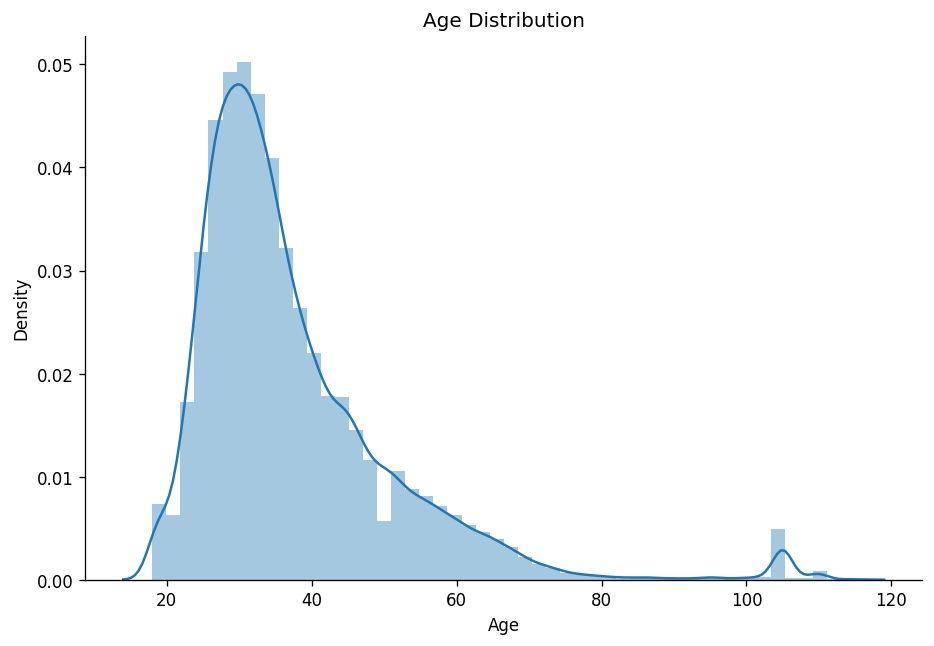

In [85]:
plt.figure(figsize=(9,6))
sns.distplot(x=user_data['age']);
plt.xlabel('Age')
plt.title('Age Distribution')
sns.despine();

*Notes:*
- The distribution of the `age` column is skewed to the right.
- In this case the median is a more representative central tendency measure.

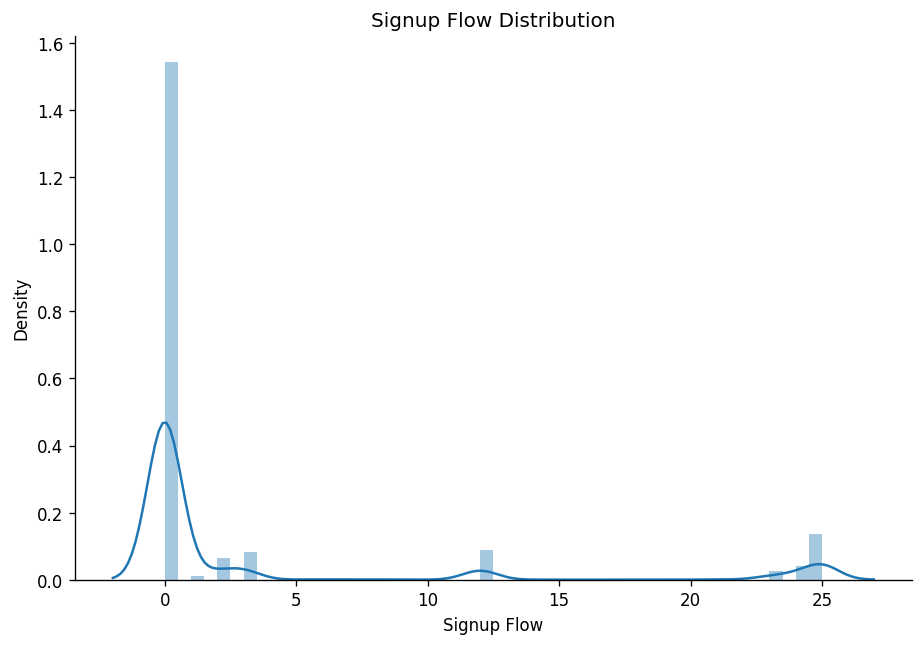

In [86]:
plt.figure(figsize=(9,6))
sns.distplot(x=user_data['signup_flow']);
plt.xlabel('Signup Flow')
plt.title('Signup Flow Distribution')
sns.despine();

*Notes:*
- The `signup_flow` is a categorical column that is already encoded and hence we are unable to extract meaningful insights from the distribution.
- That said, the histogram shows that most of the records have a value of $0$ for this column.

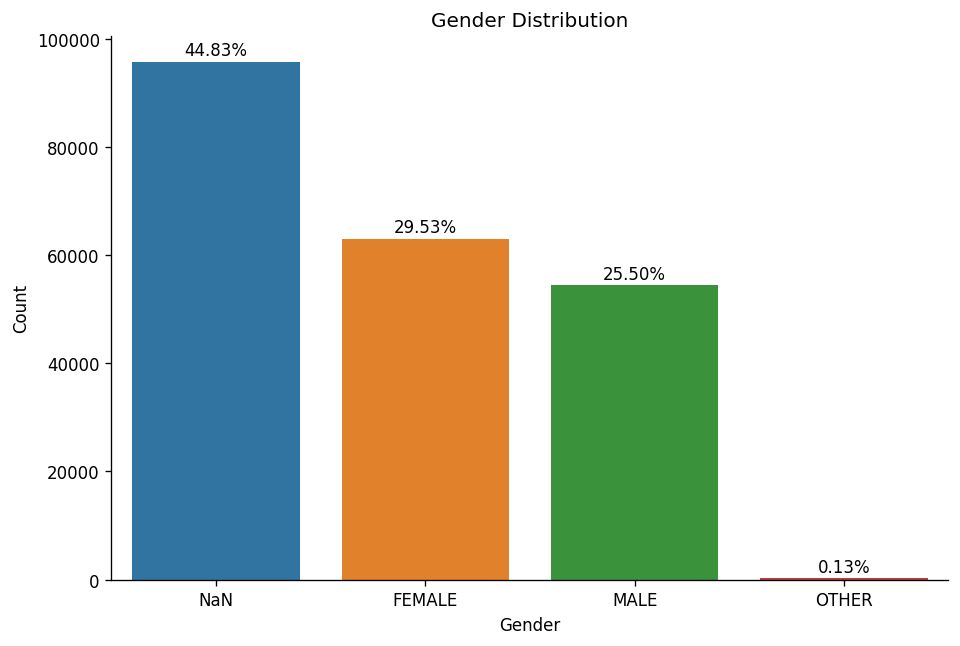

In [87]:
plt.figure(figsize=(9,6))
counts = user_data['gender'].fillna('NaN').value_counts(dropna=False)
counts_order = counts.index
sns.countplot(x=user_data['gender'].fillna('NaN'), order=counts_order);
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
for i in range(counts.shape[0]):
    plt.text(i, counts[i]+1200, f"{counts[i]/user_data.shape[0]*100:0.2f}%", ha='center', fontsize=10)
sns.despine();

*Notes:*
- The `gender` column has a slight imbalance since females are a little more frequent.
- The null value count, though, is almost at 50%. It may have been an optional information during member registration or a follow-up profile completion step. Further investigation might extract useful insights.

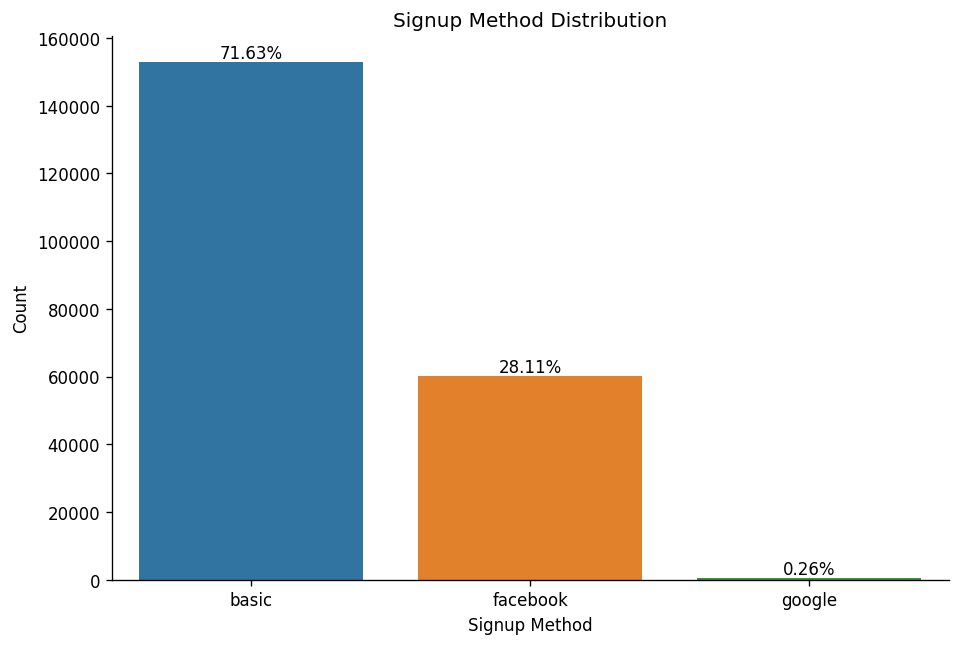

In [88]:
plt.figure(figsize=(9,6))
counts = user_data['signup_method'].value_counts()
counts_order = counts.index
sns.countplot(x=user_data['signup_method'], order=counts_order);
plt.xlabel('Signup Method')
plt.ylabel('Count')
plt.title('Signup Method Distribution')
for i in range(counts.shape[0]):
    plt.text(i, counts[i]+1200, f"{counts[i]/user_data.shape[0]*100:0.2f}%", ha='center', fontsize=10)
sns.despine();

*Notes:*
- The majority of the members signed up through the basic method, which is expected, but the interesting insight is that more than 28% signed up through Facebook.
- This can be utilised to gather more information regarding their interests and circles, within the legal limitations of course.

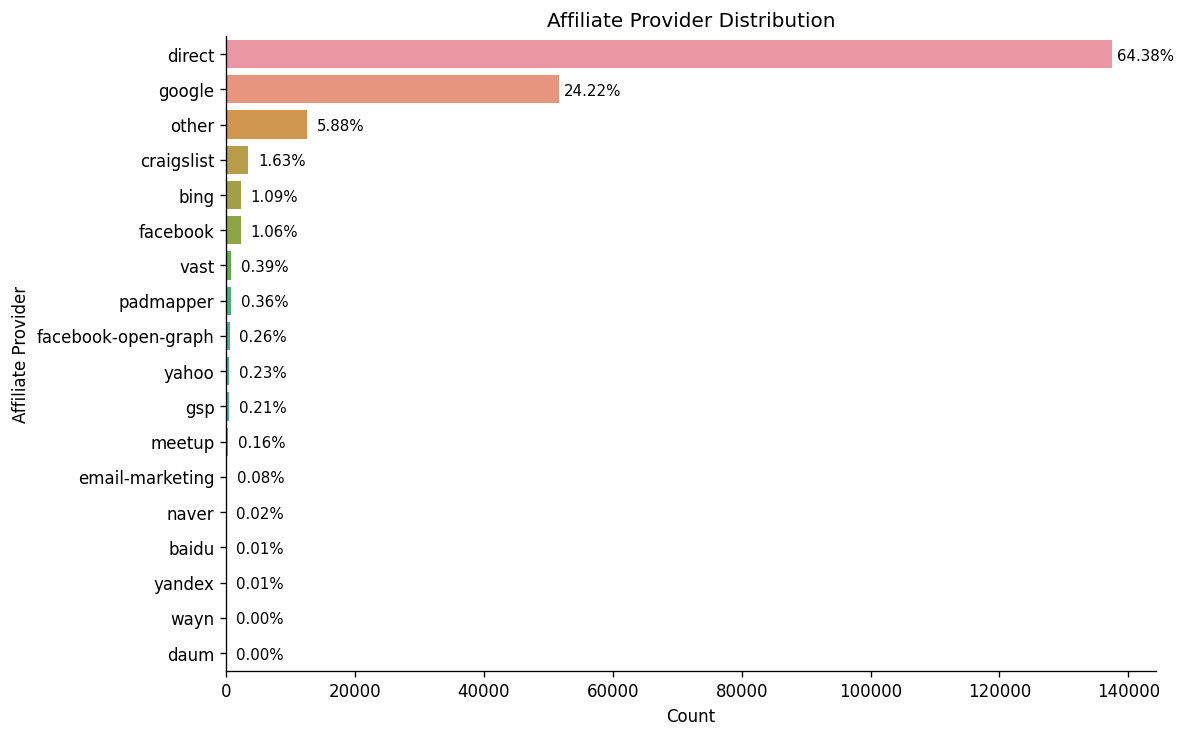

In [89]:
plt.figure(figsize=(10,7))
counts = user_data['affiliate_provider'].value_counts()
counts_order = counts.index
sns.countplot(y=user_data['affiliate_provider'], order=counts_order);
plt.ylabel('Affiliate Provider')
plt.xlabel('Count')
plt.title('Affiliate Provider Distribution')
for i in range(counts.shape[0]):
    plt.text(counts[i]+5200, i+0.17, f"{counts[i]/user_data.shape[0]*100:0.2f}%", ha='center', fontsize=9)
sns.despine();

*Notes:*
- 24% of the members were attracted through Google. The other providers contribute with less than 12%.
- It may be useful to invest more in Google affiliate channels.

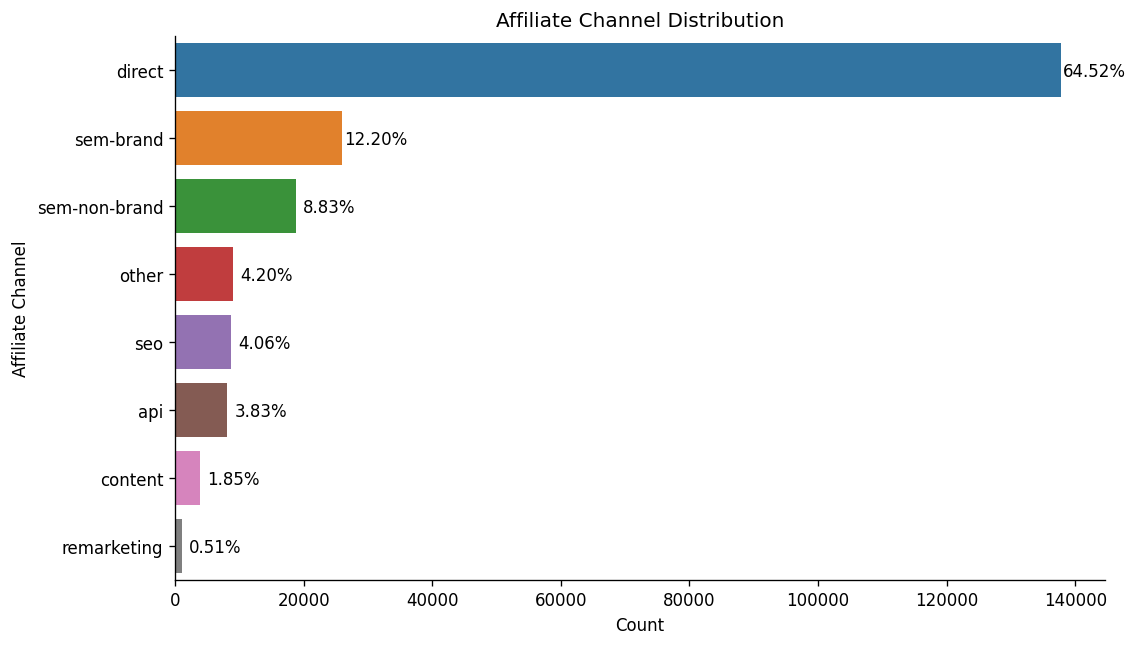

In [90]:
plt.figure(figsize=(10,6))
counts = user_data['affiliate_channel'].value_counts()
counts_order = counts.index
sns.countplot(y=user_data['affiliate_channel'], order=counts_order);
plt.ylabel('Affiliate Channel')
plt.xlabel('Count')
plt.title('Affiliate Channel Distribution')
for i in range(counts.shape[0]):
    plt.text(counts[i]+5200, i+0.09, f"{counts[i]/user_data.shape[0]*100:0.2f}%", ha='center', fontsize=10)
sns.despine();

*Notes:*
- We see that more than 24% of the channels are search engine related, namely SEM and SEO.
- This is consistent with the previous plot that showed Google as the highest non-direct affiliate provider with about 24% contribution.

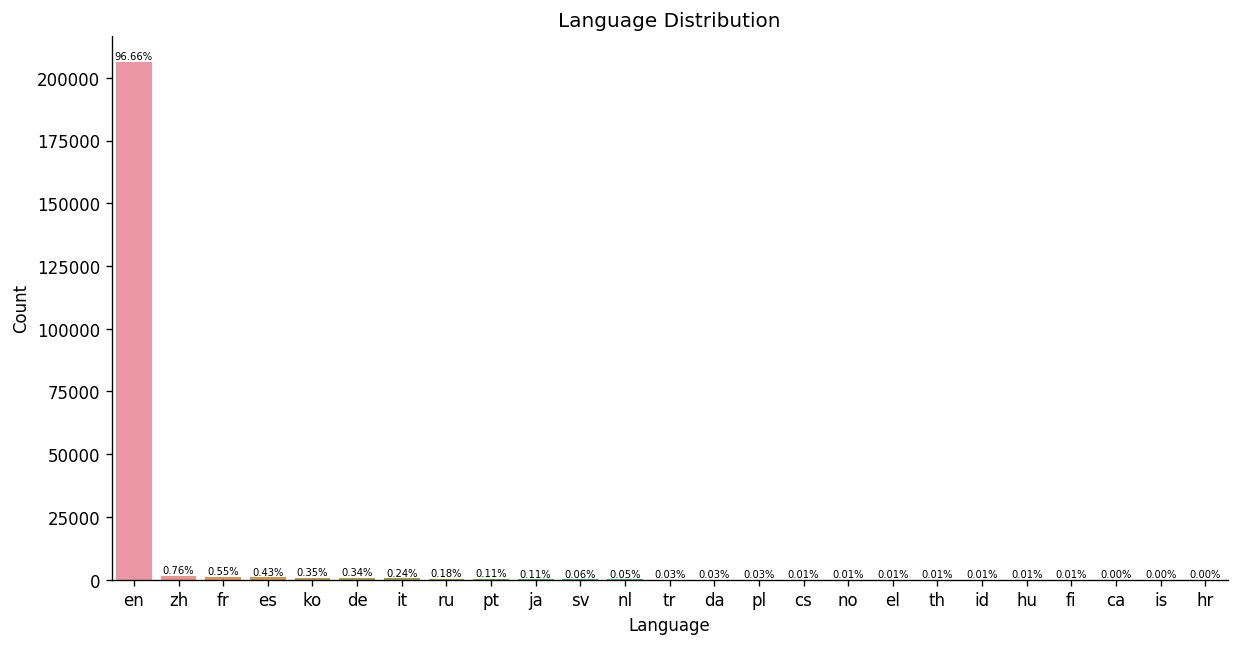

In [91]:
plt.figure(figsize=(12,6))
counts = user_data['language'].value_counts()
counts_order = counts.index
sns.countplot(x=user_data['language'], order=counts_order);
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Language Distribution')
for i in range(counts.shape[0]):
    plt.text(i, counts[i]+1000, f"{counts[i]/user_data.shape[0]*100:0.2f}%", ha='center', fontsize=6)
sns.despine();

*Notes:*
- 96.7% of the members speak English.
- This is quite expected since all the users in the dataset are from the USA.
- Since there's a huge gap in frequency among the languages, I doubt it would be possible to draw a lot of meaningful insights from this column.

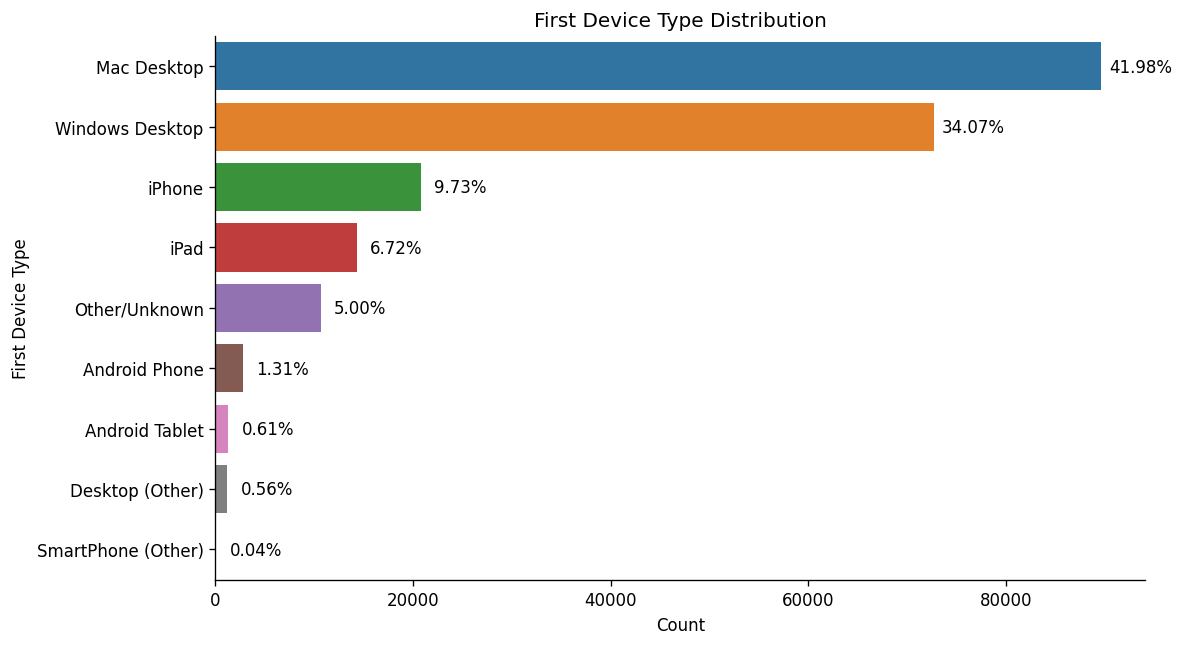

In [92]:
plt.figure(figsize=(10,6))
counts = user_data['first_device_type'].value_counts()
counts_order = counts.index
sns.countplot(data=user_data, y='first_device_type', order=counts_order);
plt.ylabel('First Device Type')
plt.xlabel('Count')
plt.title('First Device Type Distribution')
for i in range(counts.shape[0]):
    plt.text(counts[i]+4000, i+0.09, f"{counts[i]/user_data.shape[0]*100:0.2f}%", ha='center', fontsize=10)
sns.despine();

*Notes:*
- The distribution shows that about 76% of the users used a Desktop computer for their first time visiting the Airbnb website. Also, another 7.3% goes towards tablets. 
- That shows that people prefer to be settled, maybe at home, when taking a decision to travel, in contrary to doing so on the phone while commuting and such.
- This might be different though if we were to measure it nowadays since we use smartphones for mostly everything.

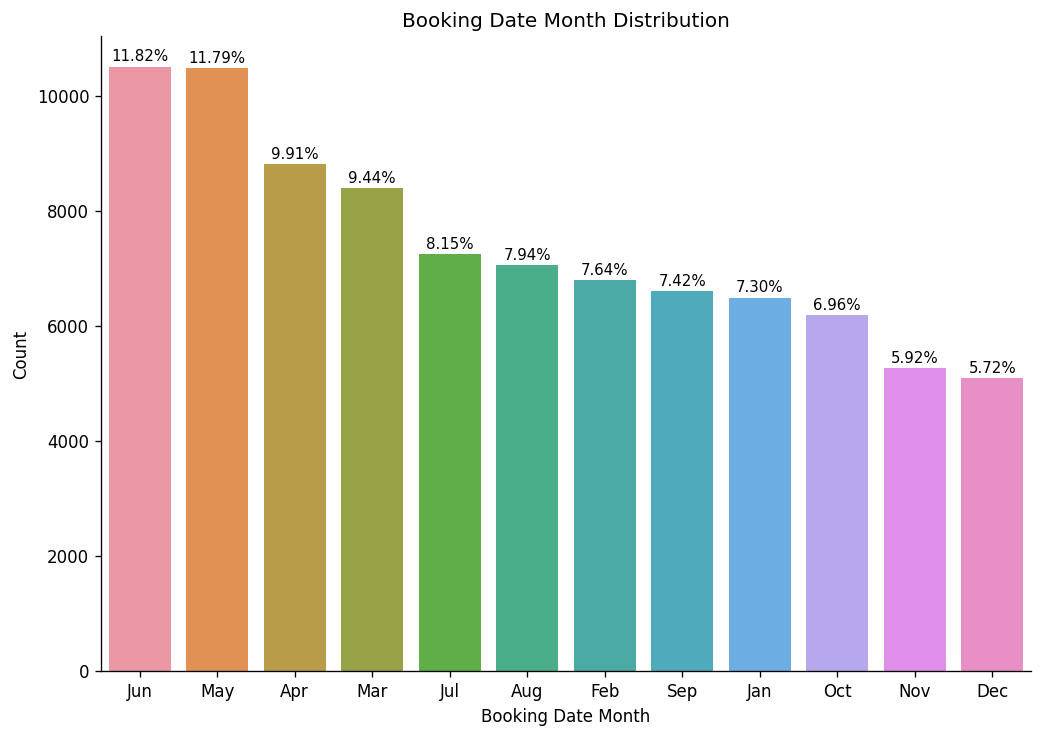

In [93]:
plt.figure(figsize=(10,7))
months_freq = user_data['date_first_booking'].dropna().dt.month_name().str[:3]
counts = months_freq.value_counts()
counts_order = counts.index
sns.countplot(x=months_freq, order=counts_order);
plt.xlabel('Booking Date Month')
plt.ylabel('Count')
plt.title('Booking Date Month Distribution')
for i in range(counts.shape[0]):
    plt.text(i, counts[i]+100, f"{counts[i]/months_freq.shape[0]*100:0.2f}%", ha='center', fontsize=9)
sns.despine();

*Notes:*
- We can see that the booking rates peak in June and May, and reach their lowest in November and December.
- That can be related to seasons. Where people prefer spring and summer to travel in contrary to winter and autumn.

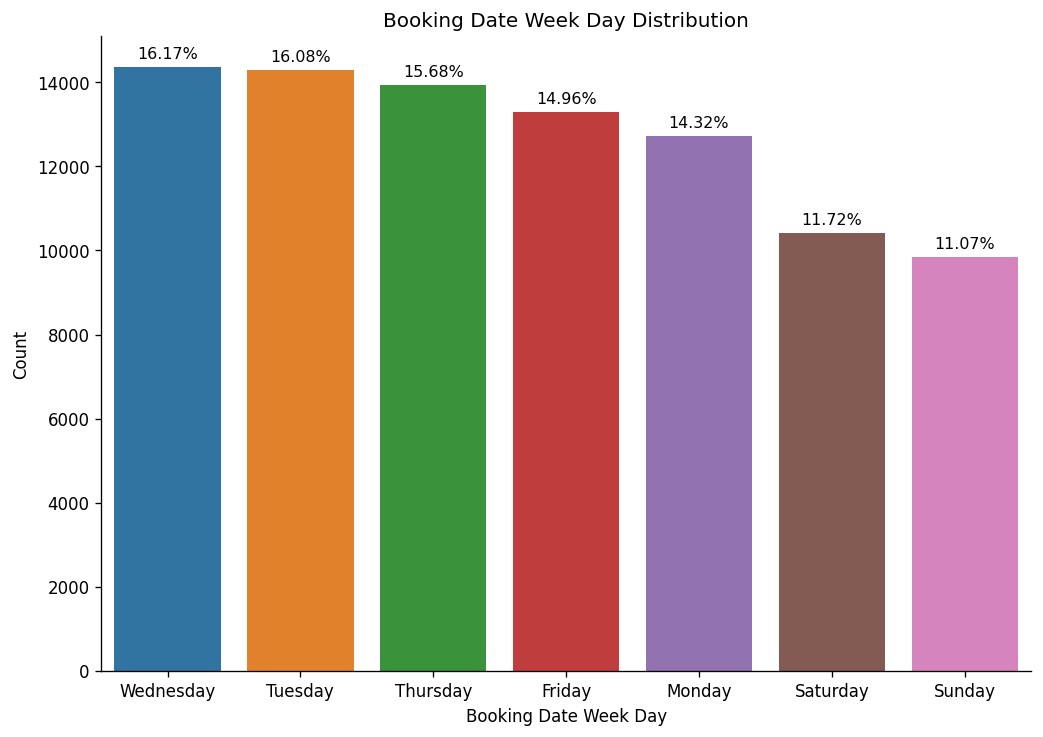

In [94]:
plt.figure(figsize=(10,7))
week_days_freq = user_data['date_first_booking'].dropna().dt.day_name()
counts = week_days_freq.value_counts()
counts_order = counts.index
sns.countplot(x=week_days_freq, order=counts_order);
plt.xlabel('Booking Date Week Day')
plt.ylabel('Count')
plt.title('Booking Date Week Day Distribution')
for i in range(counts.shape[0]):
    plt.text(i, counts[i]+200, f"{counts[i]/week_days_freq.shape[0]*100:0.2f}%", ha='center', fontsize=9.5)
sns.despine();

*Notes:*
- Apparently, booking rates are the lowest on the weekends, which might seem counter-intuitive.
- This can be explained by considering the fact that usually people don't wait till the weekend to book for their travel; they usually do that beforehand.
- The rates of booking are the highest on Wednesday and Teusday.

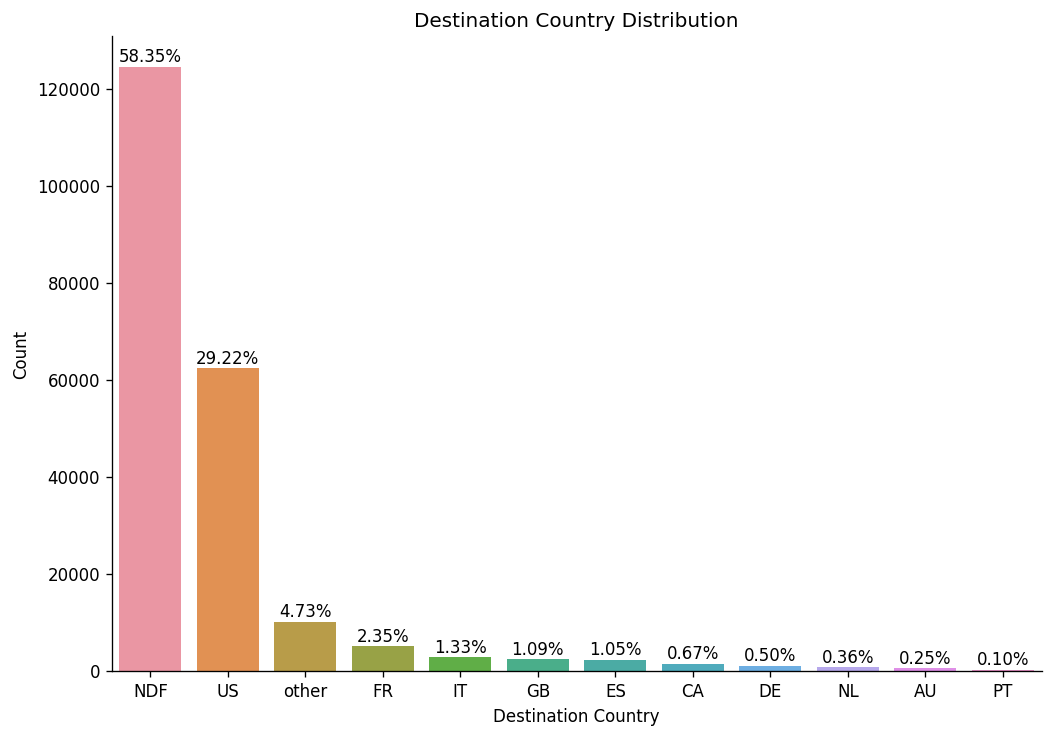

In [95]:
plt.figure(figsize=(10,7))
counts = user_data['country_destination'].value_counts()
counts_order = counts.index
sns.countplot(x=user_data['country_destination'], order=counts_order);
plt.xlabel('Destination Country')
plt.ylabel('Count')
plt.title('Destination Country Distribution')
for i in range(counts.shape[0]):
    plt.text(i, counts[i]+1000, f"{counts[i]/user_data.shape[0]*100:0.2f}%", ha='center', fontsize=10)
sns.despine();

*Notes:*
- The plot shows that almost 60% of the members who register end up not booking. While 29% book a flight locally inside the USA.
- This column being the target column, it shows a huge imbalance between the 12 classes. That will prove a challenge for simple models.

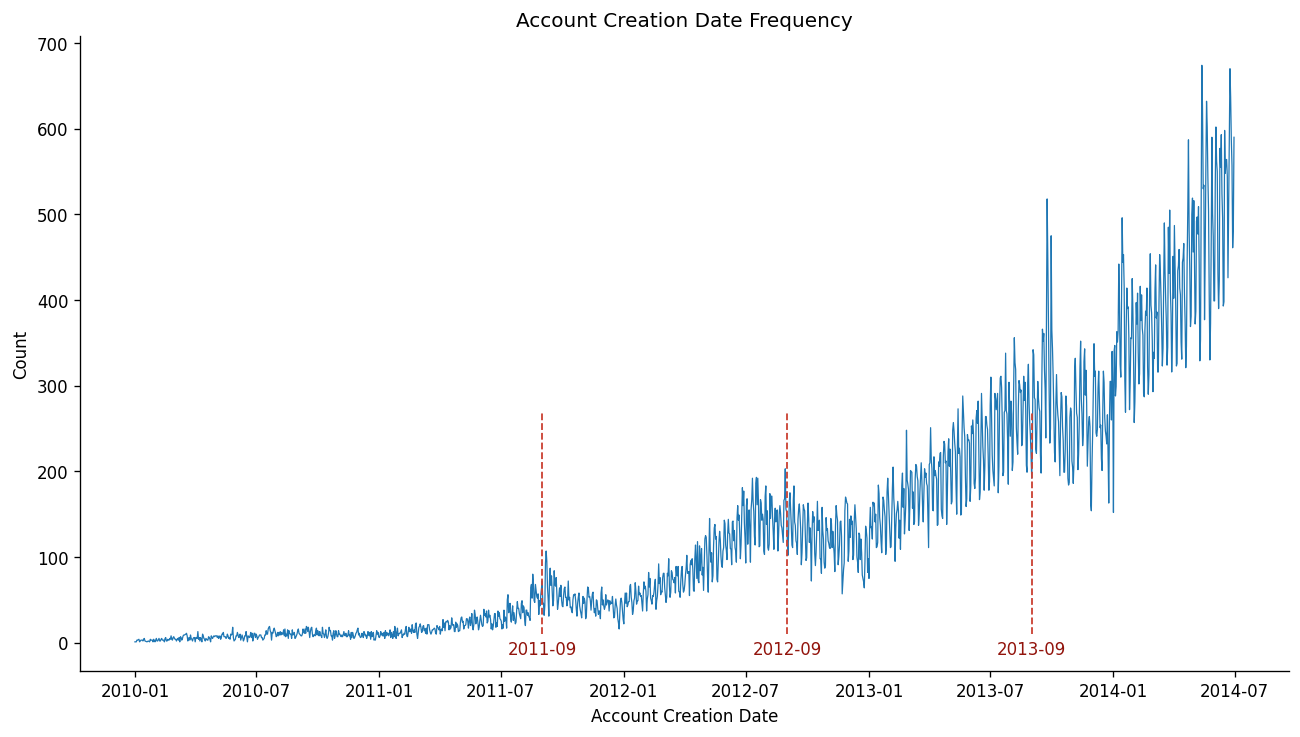

In [96]:
plt.figure(figsize=(13,7))
creation_dates = user_data['date_account_created'].value_counts()
sns.lineplot(x=creation_dates.index, y=creation_dates, size=1, legend=None);
plt.xlabel('Account Creation Date')
plt.ylabel('Count')
plt.title('Account Creation Date Frequency')
anomalies = ['2011-09', '2012-09', '2013-09']
plt.vlines(anomalies, 10, 270, colors='#CB4335', linestyles='dashed', linewidths=1.1)
for i in range(3):
    plt.text(pd.to_datetime(anomalies[i], format = '%Y-%m'), -14, f"{anomalies[i]}", ha='center', color='#92140C')
sns.despine();

*Notes:*
- It seems that there is a spike in account creation around July and September of each year.
- That might be connected to the public holidays in the USA (Independence Day, Labor Day, etc.).

### Bivariate Analysis

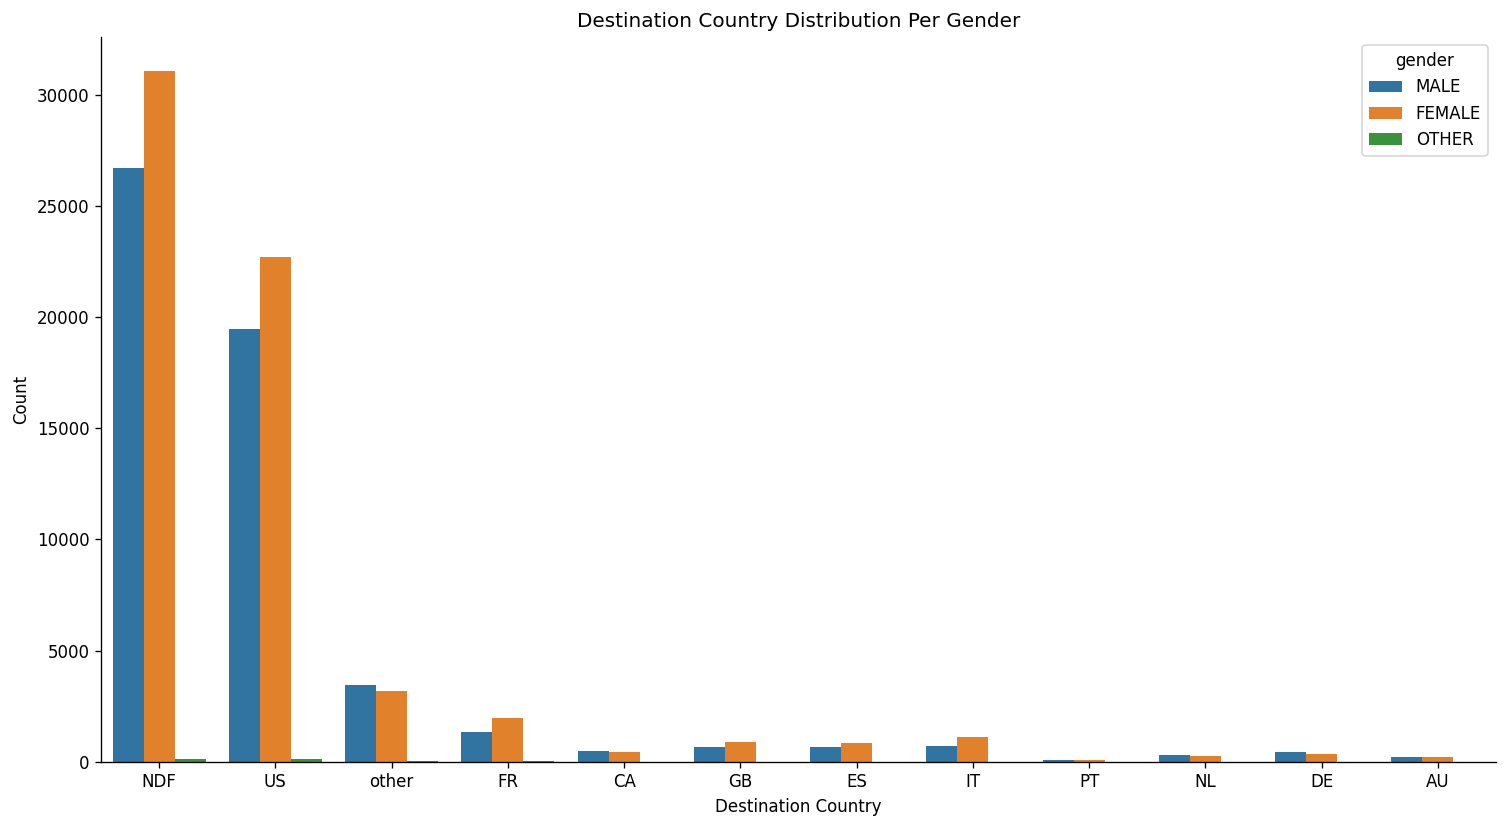

In [97]:
plt.figure(figsize=(15,8))
sns.countplot(data=user_data, x='country_destination', hue='gender');
plt.xlabel('Destination Country')
plt.ylabel('Count')
plt.title('Destination Country Distribution Per Gender')
sns.despine();

*Notes:*
- We can see that countries such as Canada, Purtugal, Netherlands, Germany and other attract more male members than female.
- It may not be a huge difference, but could be useful to target male members with more ads for these countries.

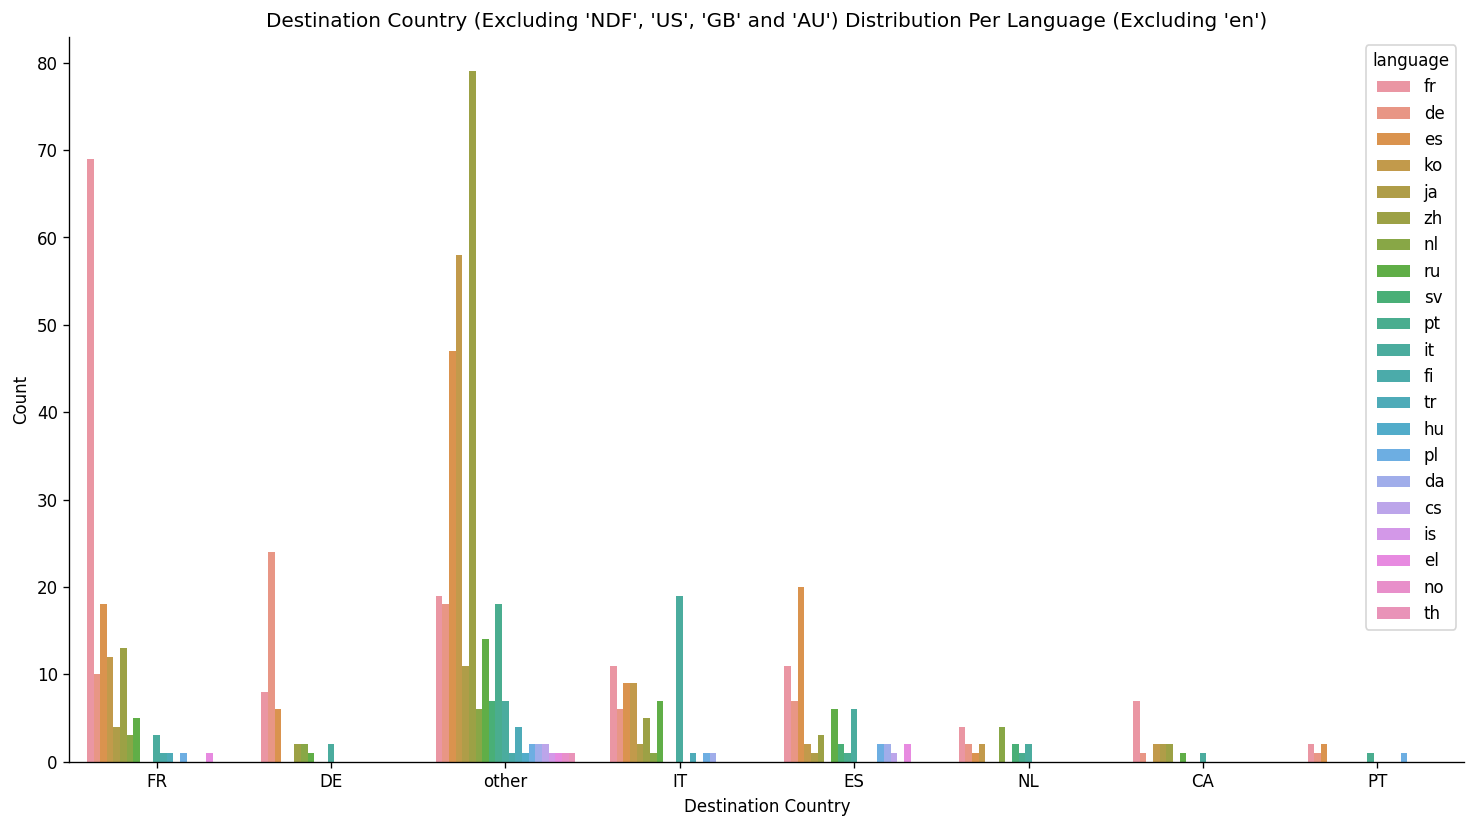

In [98]:
plt.figure(figsize=(15,8))
non_en_users_other = user_data[np.logical_and(user_data['language']!='en', np.logical_not(user_data['country_destination'].isin(['NDF', 'US', 'AU', 'GB'])))]
g = sns.countplot(data=non_en_users_other, x='country_destination', hue='language');
plt.xlabel('Destination Country')
plt.ylabel('Count')
plt.title('Destination Country (Excluding \'NDF\', \'US\', \'GB\' and \'AU\') Distribution Per Language (Excluding \'en\')')
sns.move_legend(g, "upper right")
sns.despine();

*Notes:*
- It is quite corwded in the plot, but we can extract a piece of meaningful information from it.
- We can see that apart from English, the language with highest frequency in visiting each country is an official language in that country almost in every case.
- It may sound obvious, but it's worth noting that the marketing strategy should utilise this to increase the booking rates.

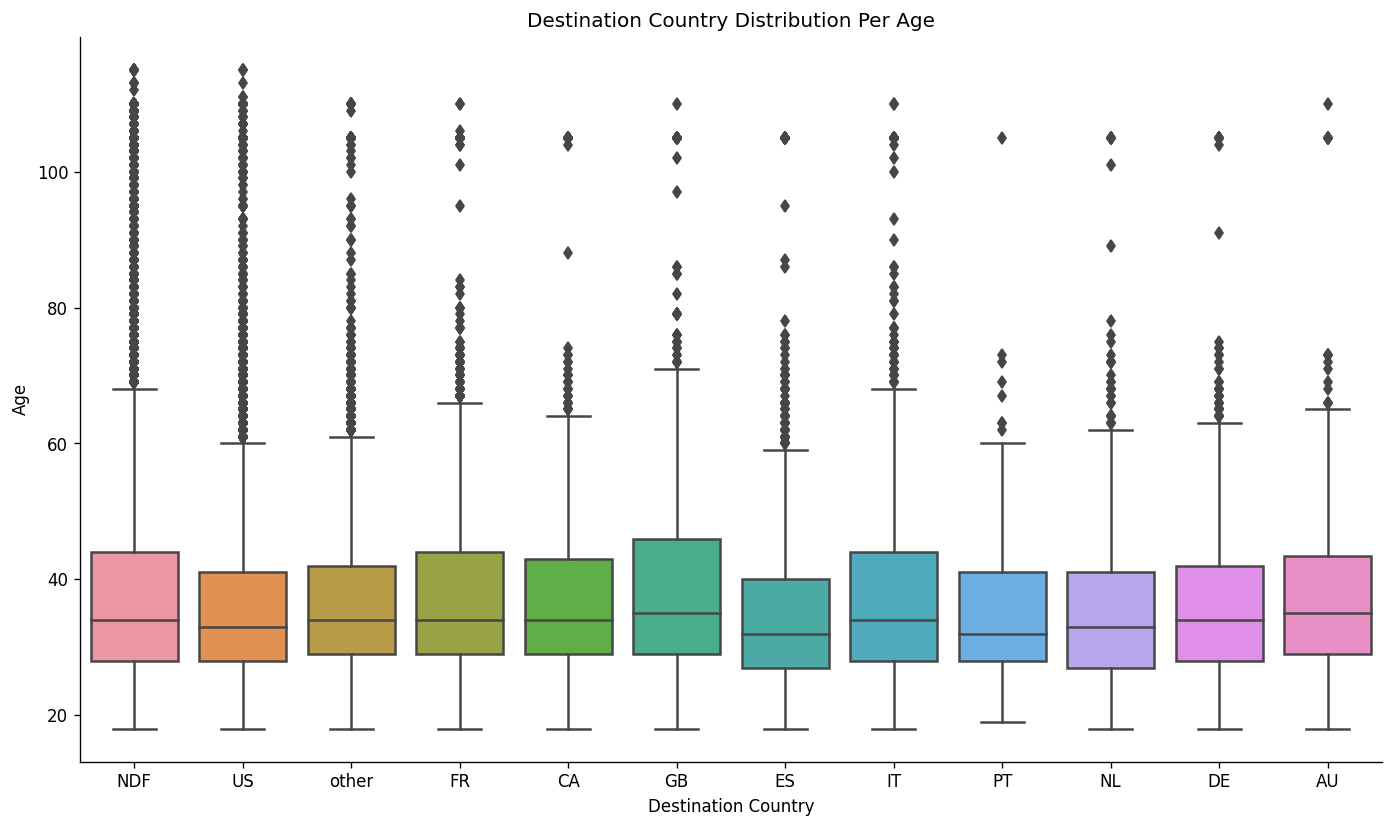

In [99]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(14, 8))
sns.boxplot(data=user_data, y='age', x='country_destination', ax=ax)
plt.xlabel('Destination Country')
plt.ylabel('Age')
plt.title('Destination Country Distribution Per Age')
sns.despine();

*Notes:*
- It may be slight deferences, but we can see that younger members tend to visit Spain and Portugal more often.
- On the other hand, older members prefer the United Kingdom.

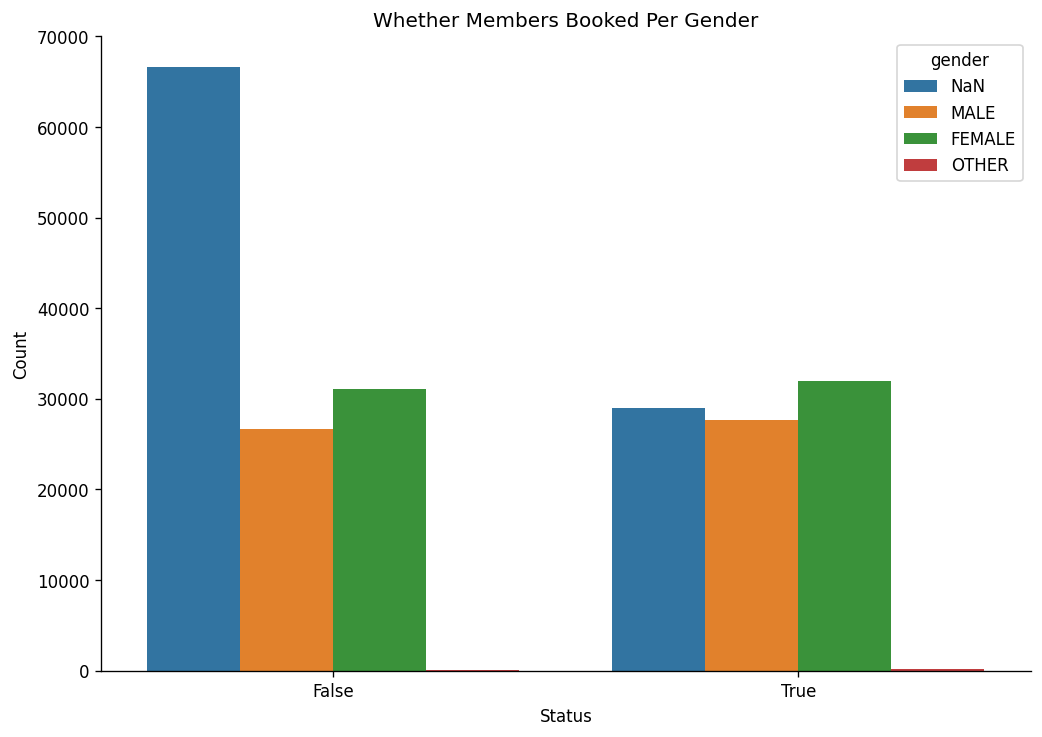

In [100]:
plt.figure(figsize=(10,7))
gender_ndf = pd.concat([user_data['gender'].fillna('NaN'), np.logical_not(user_data.date_first_booking.rename('Booked').isna())], axis=1)
g = sns.countplot(data=gender_ndf, x='Booked', hue='gender');
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Whether Members Booked Per Gender')
sns.despine();

*Notes:*
- The plot above shows that the members who didn't specify a gender mostly ended up not booking.
- This may be justified as a measure of how serious the members are during registration. If members are serious about booking they usually will invest more time to complete their profile.
- This can be utilised to target members with complete profiles with more ads since they may have more potential of booking.

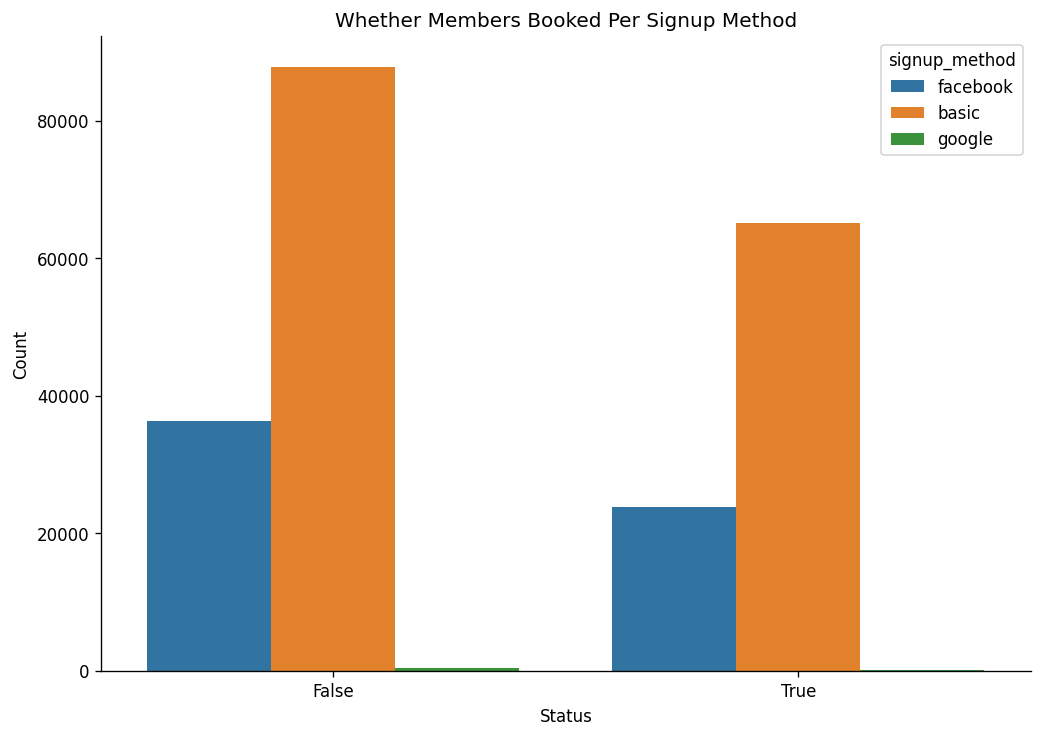

In [101]:
plt.figure(figsize=(10,7))
signup_ndf = pd.concat([user_data['signup_method'], np.logical_not(user_data.date_first_booking.isna())], axis=1)
sns.countplot(data=signup_ndf, x='date_first_booking', hue='signup_method');
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Whether Members Booked Per Signup Method')
sns.despine();

*Notes:*
- It seems that both categories have similar distributions. That means we cannot draw meaningful insights related to the signup method used.

-------------------

# `06` eXtreme Gradient Boosting Classifier (XGBClassifier)

In [102]:
# NDCG Score Metric Function
# Reference: https://www.kaggle.com/davidgasquez/ndcg-scorer

def dcg_score(y_true, y_score, k=5):
    
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score_udf(ground_truth, predictions, k=5):
    
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    
    lb = LabelBinarizer()
    lb.fit(range(predictions.shape[1] + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

# Create the scorer with NDCG score metric function
ndcg_scorer = make_scorer(ndcg_score_udf, needs_proba=True, k=5)

## `0` Feature Importance

- I performed a quick initial `RandomizedSearchCV` for the first time on the whole feature set -which took a lot of time due to the number of features-.
- Using the best estimator from the `RandomizedSearchCV`, I extracted the feature importance.
- I will use feature selection based on their importance from this point forward to reduce hyperparameter tuning time.
- In case of finding estimators with better scores, I will them instead of this one for submission.

In [103]:
# Initialize an estimator with the best param set from the first tuning session
gb_best1 = XGBClassifier(objective='multi:softprob',eval_metric= 'ndcg',
       learning_rate=0.1, max_depth=3, min_child_weight=0.5, n_estimators=100, n_jobs=4, random_state=42)

# Fit on the whole training dataset
gb_best1.fit(x_train, y_train)

# Calculating NDCG Score on the training set
best1_score = ndcg_score_udf(y_train, gb_best1.predict_proba(x_train))
print(f"NDCG Training Score on the first best estimator: {best1_score}")

# Extracting feature importance
feat_importance = gb_best1.feature_importances_

# Getting the sorted indices to implement feature selection later
sorted_indices = np.argsort(feat_importance)

# Getting the index of the first feature with importance less than a threshold (for example 0.001)
print(f"The index of the first feature with importance less than 0.001 is: {np.where(np.array(sorted(feat_importance, reverse=True)) < 0.001)[0][0]}")

NDCG Training Score on the first best estimator: 0.8318630984687463
The index of the first feature with importance less than 0.001 is: 215


## `i` Model Hyper Parameters Tuning

- I will try to tune the XGBoost hyperparameters to the extreme.
- For each set of parameters, I will use a wider range of values first.
- Then I will use a narrower range to fine tune the parameters.

In [104]:
import xgboost as xgb

def get_optimum_n(model, X_train, y_train, X_test=None, y_test=None, k=5, early_stopping_n=50, verbose=False):
    """Obtain the optimum n_estimators for a given set of parameters through Cross Validation."""
    # Perform Cross Validation to determine the optimum n_estimators
    params = model.get_xgb_params()
    dtrain = xgb.DMatrix(X_train, y_train)
    cv_res = xgb.cv(params, dtrain, num_boost_round=model.get_params()['n_estimators'], nfold=k,
            metrics='mlogloss', early_stopping_rounds=early_stopping_n, verbose_eval=verbose)
    optimum_n=cv_res.shape[0]
    print(f"The optimum n_estimator: {optimum_n}")
    
    # Try the optimum n_estimators obtained
    model.set_params(n_estimators=optimum_n)
    model.fit(X_train, y_train)
    
    # Calculate training score
    y_pred_prob = model.predict_proba(X_train)
    score = ndcg_score_udf(y_train, y_pred_prob)
    print(f"Training NDCG Score: {score*100:0.4f}%")
    
    # Calculate test score
    if X_test and y_test:
        y_test_pred_prob = model.predict_proba(X_test)
        score = ndcg_score_udf(y_test, y_test_pred_prob)
        print(f"Test NDCG Score: {score*100:0.4f}%")
    
    return optimum_n

### Determine Optimum `n_estimators` for High Learning Rate

In [105]:
# Initialize an XGBClassifier instance with initial parameter values
xgb_model = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=400,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

# Start CV
n_est_opt = get_optimum_n(xgb_model, x_train[:, sorted_indices[:214]], y_train)

The optimum n_estimator: 106
Training NDCG Score: 80.9083%


### Tuning `max_depth` and `min_child_weight` Parameters

In [106]:
param_test1 = {
 'max_depth': range(3, 10, 2),
 'min_child_weight': range(1, 6, 2)
}

model_test1 = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=106,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

clf_test1 = GridSearchCV(estimator=model_test1, param_grid=param_test1, scoring=ndcg_scorer, verbose=5, cv=5)

clf_test1.fit(x_train[:, sorted_indices[:214]], y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...max_depth=3, min_child_weight=1;, score=0.807 total time=  31.2s
[CV 2/5] END ...max_depth=3, min_child_weight=1;, score=0.807 total time=  30.9s
[CV 3/5] END ...max_depth=3, min_child_weight=1;, score=0.807 total time=  31.3s
[CV 4/5] END ...max_depth=3, min_child_weight=1;, score=0.808 total time=  32.3s
[CV 5/5] END ...max_depth=3, min_child_weight=1;, score=0.809 total time=  31.3s
[CV 1/5] END ...max_depth=3, min_child_weight=3;, score=0.807 total time=  31.0s
[CV 2/5] END ...max_depth=3, min_child_weight=3;, score=0.807 total time=  31.1s
[CV 3/5] END ...max_depth=3, min_child_weight=3;, score=0.807 total time=  31.4s
[CV 4/5] END ...max_depth=3, min_child_weight=3;, score=0.808 total time=  31.9s
[CV 5/5] END ...max_depth=3, min_child_weight=3;, score=0.809 total time=  31.4s
[CV 1/5] END ...max_depth=3, min_child_weight=5;, score=0.807 total time=  31.2s
[CV 2/5] END ...max_depth=3, min_child_weight=5;

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='ndcg', gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_t...
                                     max_delta_step=None, max_depth=6,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                        

In [107]:
display(pd.DataFrame(clf_test1.cv_results_))
clf_test1.best_params_, clf_test1.best_score_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,28.642357,0.461918,2.754580,0.021191,3,1,"{'max_depth': 3, 'min_child_weight': 1}",0.806763,0.806763,0.806763,0.807719,0.808723,0.807346,0.000782,2
1,28.705004,0.353050,2.662286,0.030229,3,3,"{'max_depth': 3, 'min_child_weight': 3}",0.806763,0.806763,0.806772,0.807760,0.808661,0.807344,0.000763,3
2,28.678574,0.166937,2.656527,0.058425,3,5,"{'max_depth': 3, 'min_child_weight': 5}",0.806763,0.806763,0.806773,0.807709,0.808730,0.807348,0.000782,1
3,37.581791,0.519479,3.135495,0.076427,5,1,"{'max_depth': 5, 'min_child_weight': 1}",0.806763,0.806748,0.806773,0.807348,0.808563,0.807239,0.000700,5
4,36.949950,0.884746,3.148758,0.131088,5,3,"{'max_depth': 5, 'min_child_weight': 3}",0.806763,0.806755,0.806773,0.807295,0.808457,0.807209,0.000657,6
5,36.030107,0.817514,3.083416,0.135983,5,5,"{'max_depth': 5, 'min_child_weight': 5}",0.806754,0.806760,0.806773,0.807503,0.808685,0.807295,0.000752,4
6,46.022630,1.034465,4.060287,0.250043,7,1,"{'max_depth': 7, 'min_child_weight': 1}",0.806763,0.806745,0.806773,0.807026,0.808327,0.807127,0.000609,10
7,45.009654,0.613170,3.724122,0.100682,7,3,"{'max_depth': 7, 'min_child_weight': 3}",0.806745,0.806747,0.806781,0.807123,0.808322,0.807144,0.000606,9
8,43.690503,1.470100,3.651645,0.165579,7,5,"{'max_depth': 7, 'min_child_weight': 5}",0.806754,0.806747,0.806782,0.807191,0.808520,0.807199,0.000681,7
9,54.136653,1.452733,4.475093,0.051881,9,1,"{'max_depth': 9, 'min_child_weight': 1}",0.806754,0.806738,0.806776,0.806808,0.807979,0.807011,0.000485,12


({'max_depth': 3, 'min_child_weight': 5}, 0.8073475683325576)

In [108]:
param_test1a = {
 'max_depth': [2, 3, 4],
 'min_child_weight': [4, 5, 6]
}

model_test1a = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=106,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

clf_test1a = GridSearchCV(estimator=model_test1a, param_grid=param_test1a, scoring=ndcg_scorer, verbose=5, cv=5)

clf_test1a.fit(x_train[:, sorted_indices[:214]], y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ...max_depth=2, min_child_weight=4;, score=0.807 total time=  26.0s
[CV 2/5] END ...max_depth=2, min_child_weight=4;, score=0.807 total time=  26.1s
[CV 3/5] END ...max_depth=2, min_child_weight=4;, score=0.807 total time=  26.6s
[CV 4/5] END ...max_depth=2, min_child_weight=4;, score=0.808 total time=  26.9s
[CV 5/5] END ...max_depth=2, min_child_weight=4;, score=0.809 total time=  27.5s
[CV 1/5] END ...max_depth=2, min_child_weight=5;, score=0.807 total time=  26.8s
[CV 2/5] END ...max_depth=2, min_child_weight=5;, score=0.807 total time=  25.9s
[CV 3/5] END ...max_depth=2, min_child_weight=5;, score=0.807 total time=  26.1s
[CV 4/5] END ...max_depth=2, min_child_weight=5;, score=0.808 total time=  27.3s
[CV 5/5] END ...max_depth=2, min_child_weight=5;, score=0.809 total time=  27.1s
[CV 1/5] END ...max_depth=2, min_child_weight=6;, score=0.807 total time=  26.6s
[CV 2/5] END ...max_depth=2, min_child_weight=6;,

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='ndcg', gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_t...
                                     max_delta_step=None, max_depth=6,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                        

In [109]:
display(pd.DataFrame(clf_test1a.cv_results_))
clf_test1a.best_params_, clf_test1a.best_score_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,24.155014,0.520426,2.482543,0.020153,2,4,"{'max_depth': 2, 'min_child_weight': 4}",0.806763,0.806763,0.806763,0.807948,0.808780,0.807403,0.000827,2
1,24.144390,0.603452,2.497081,0.072304,2,5,"{'max_depth': 2, 'min_child_weight': 5}",0.806763,0.806763,0.806763,0.807958,0.808750,0.807400,0.000819,3
2,24.994996,0.647182,2.618439,0.101079,2,6,"{'max_depth': 2, 'min_child_weight': 6}",0.806763,0.806781,0.806763,0.807942,0.808822,0.807414,0.000838,1
3,29.247057,0.580443,2.878025,0.051553,3,4,"{'max_depth': 3, 'min_child_weight': 4}",0.806763,0.806763,0.806773,0.807773,0.808673,0.807349,0.000768,5
4,28.300277,0.680435,2.728381,0.075351,3,5,"{'max_depth': 3, 'min_child_weight': 5}",0.806763,0.806763,0.806773,0.807709,0.808730,0.807348,0.000782,6
5,29.068304,0.882342,2.789181,0.093160,3,6,"{'max_depth': 3, 'min_child_weight': 6}",0.806763,0.806763,0.806773,0.807784,0.808731,0.807363,0.000790,4
6,31.660873,1.505923,2.829698,0.172501,4,4,"{'max_depth': 4, 'min_child_weight': 4}",0.806763,0.806763,0.806773,0.807646,0.808622,0.807314,0.000738,9
7,31.852489,0.989404,2.953817,0.055861,4,5,"{'max_depth': 4, 'min_child_weight': 5}",0.806763,0.806762,0.806773,0.807649,0.808666,0.807323,0.000754,8
8,31.509988,1.523848,2.838269,0.120525,4,6,"{'max_depth': 4, 'min_child_weight': 6}",0.806763,0.806762,0.806773,0.807628,0.808762,0.807338,0.000787,7


({'max_depth': 2, 'min_child_weight': 6}, 0.8074140390306569)

In [110]:
param_test1b = {
 'min_child_weight':[6,8,10,12]
}

model_test1b = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=106,
    max_depth=2,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

clf_test1b = GridSearchCV(estimator=model_test1b, param_grid=param_test1b, scoring=ndcg_scorer, verbose=5, cv=5)

clf_test1b.fit(x_train[:, sorted_indices[:214]], y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................min_child_weight=6;, score=0.807 total time=  24.5s
[CV 2/5] END ................min_child_weight=6;, score=0.807 total time=  25.4s
[CV 3/5] END ................min_child_weight=6;, score=0.807 total time=  25.5s
[CV 4/5] END ................min_child_weight=6;, score=0.808 total time=  25.9s
[CV 5/5] END ................min_child_weight=6;, score=0.809 total time=  26.2s
[CV 1/5] END ................min_child_weight=8;, score=0.807 total time=  25.1s
[CV 2/5] END ................min_child_weight=8;, score=0.807 total time=  26.5s
[CV 3/5] END ................min_child_weight=8;, score=0.807 total time=  28.0s
[CV 4/5] END ................min_child_weight=8;, score=0.808 total time=  29.4s
[CV 5/5] END ................min_child_weight=8;, score=0.809 total time=  28.9s
[CV 1/5] END ...............min_child_weight=10;, score=0.807 total time=  27.5s
[CV 2/5] END ...............min_child_weight=10;,

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='ndcg', gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_t...t=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                 

In [111]:
display(pd.DataFrame(clf_test1b.cv_results_))
clf_test1b.best_params_, clf_test1b.best_score_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,23.216041,0.599019,2.286453,0.031918,6,{'min_child_weight': 6},0.806763,0.806781,0.806763,0.807942,0.808822,0.807414,0.000838,4
1,24.954892,1.580823,2.605821,0.091267,8,{'min_child_weight': 8},0.806763,0.806781,0.806763,0.807920,0.808912,0.807428,0.000866,3
2,24.212809,0.854772,2.530648,0.102647,10,{'min_child_weight': 10},0.806763,0.806772,0.806764,0.807937,0.808972,0.807442,0.000890,2
3,23.698701,0.421765,2.505596,0.080177,12,{'min_child_weight': 12},0.806763,0.806772,0.806763,0.807976,0.808996,0.807454,0.000902,1


({'min_child_weight': 12}, 0.8074538518002445)

In [112]:
param_test1c = {
 'min_child_weight':[12, 14, 16, 18, 20, 22]
}

model_test1c = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=106,
    max_depth=2,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

clf_test1c = GridSearchCV(estimator=model_test1c, param_grid=param_test1c, scoring=ndcg_scorer, verbose=5, cv=5)

clf_test1c.fit(x_train[:, sorted_indices[:214]], y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...............min_child_weight=12;, score=0.807 total time=  26.5s
[CV 2/5] END ...............min_child_weight=12;, score=0.807 total time=  28.2s
[CV 3/5] END ...............min_child_weight=12;, score=0.807 total time=  28.1s
[CV 4/5] END ...............min_child_weight=12;, score=0.808 total time=  27.9s
[CV 5/5] END ...............min_child_weight=12;, score=0.809 total time=  28.4s
[CV 1/5] END ...............min_child_weight=14;, score=0.807 total time=  26.1s
[CV 2/5] END ...............min_child_weight=14;, score=0.807 total time=  25.9s
[CV 3/5] END ...............min_child_weight=14;, score=0.807 total time=  26.4s
[CV 4/5] END ...............min_child_weight=14;, score=0.808 total time=  26.6s
[CV 5/5] END ...............min_child_weight=14;, score=0.809 total time=  28.1s
[CV 1/5] END ...............min_child_weight=16;, score=0.807 total time=  27.6s
[CV 2/5] END ...............min_child_weight=16;,

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='ndcg', gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_t...
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                        

In [113]:
display(pd.DataFrame(clf_test1c.cv_results_))
clf_test1c.best_params_, clf_test1c.best_score_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,25.341202,0.691218,2.475671,0.036387,12,{'min_child_weight': 12},0.806763,0.806772,0.806763,0.807976,0.808996,0.807454,0.000902,2
1,24.137970,0.743829,2.470940,0.067068,14,{'min_child_weight': 14},0.806763,0.806772,0.806763,0.807998,0.808974,0.807454,0.000898,1
2,25.221781,0.466428,2.496590,0.048773,16,{'min_child_weight': 16},0.806763,0.806772,0.806763,0.807907,0.808966,0.807434,0.000884,6
3,24.389998,0.266077,2.404775,0.040354,18,{'min_child_weight': 18},0.806763,0.806772,0.806763,0.807909,0.809009,0.807443,0.000899,3
4,24.628029,0.458637,2.496474,0.060942,20,{'min_child_weight': 20},0.806763,0.806772,0.806763,0.807892,0.809001,0.807438,0.000895,4
5,23.743572,0.568106,2.451961,0.063987,22,{'min_child_weight': 22},0.806763,0.806772,0.806763,0.807856,0.809021,0.807435,0.000898,5


({'min_child_weight': 14}, 0.8074541042677138)

In [114]:
param_test1d = {
    'max_depth': [2, 3, 4],
    'min_child_weight':[13, 14, 15]
}

model_test1d = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=106,
    max_depth=2,
    min_child_weight=14,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

clf_test1d = GridSearchCV(estimator=model_test1d, param_grid=param_test1d, scoring=ndcg_scorer, verbose=5, cv=5)

clf_test1d.fit(x_train[:, sorted_indices[:214]], y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..max_depth=2, min_child_weight=13;, score=0.807 total time=  26.4s
[CV 2/5] END ..max_depth=2, min_child_weight=13;, score=0.807 total time=  25.9s
[CV 3/5] END ..max_depth=2, min_child_weight=13;, score=0.807 total time=  26.0s
[CV 4/5] END ..max_depth=2, min_child_weight=13;, score=0.808 total time=  26.7s
[CV 5/5] END ..max_depth=2, min_child_weight=13;, score=0.809 total time=  27.5s
[CV 1/5] END ..max_depth=2, min_child_weight=14;, score=0.807 total time=  26.7s
[CV 2/5] END ..max_depth=2, min_child_weight=14;, score=0.807 total time=  26.7s
[CV 3/5] END ..max_depth=2, min_child_weight=14;, score=0.807 total time=  25.8s
[CV 4/5] END ..max_depth=2, min_child_weight=14;, score=0.808 total time=  25.5s
[CV 5/5] END ..max_depth=2, min_child_weight=14;, score=0.809 total time=  27.4s
[CV 1/5] END ..max_depth=2, min_child_weight=15;, score=0.807 total time=  26.1s
[CV 2/5] END ..max_depth=2, min_child_weight=15;,

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='ndcg', gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_t...
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=14,
                                     missing=nan, monotone_constraints=None,
                       

In [115]:
display(pd.DataFrame(clf_test1d.cv_results_))
clf_test1d.best_params_, clf_test1d.best_score_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,24.118429,0.605502,2.388624,0.025617,2,13,"{'max_depth': 2, 'min_child_weight': 13}",0.806763,0.806772,0.806763,0.807990,0.808992,0.807456,0.000902,1
1,23.982231,0.676464,2.431421,0.039446,2,14,"{'max_depth': 2, 'min_child_weight': 14}",0.806763,0.806772,0.806763,0.807998,0.808974,0.807454,0.000898,2
2,23.814127,0.325161,2.348171,0.037625,2,15,"{'max_depth': 2, 'min_child_weight': 15}",0.806763,0.806772,0.806763,0.807944,0.808983,0.807445,0.000894,3
3,28.007073,0.499590,2.592923,0.063843,3,13,"{'max_depth': 3, 'min_child_weight': 13}",0.806763,0.806772,0.806764,0.807772,0.808939,0.807402,0.000862,5
4,27.966584,0.168694,2.601307,0.036038,3,14,"{'max_depth': 3, 'min_child_weight': 14}",0.806763,0.806772,0.806764,0.807883,0.808912,0.807419,0.000863,4
5,27.742743,0.266315,2.530029,0.046765,3,15,"{'max_depth': 3, 'min_child_weight': 15}",0.806763,0.806772,0.806764,0.807835,0.808834,0.807393,0.000831,8
6,30.784697,0.131456,2.739133,0.029045,4,13,"{'max_depth': 4, 'min_child_weight': 13}",0.806763,0.806772,0.806773,0.807717,0.808879,0.807381,0.000834,9
7,29.516211,0.781564,2.559792,0.121711,4,14,"{'max_depth': 4, 'min_child_weight': 14}",0.806763,0.806772,0.806764,0.807712,0.808966,0.807395,0.000867,7
8,28.701825,0.128760,2.500696,0.066469,4,15,"{'max_depth': 4, 'min_child_weight': 15}",0.806763,0.806772,0.806773,0.807709,0.808978,0.807399,0.000869,6


({'max_depth': 2, 'min_child_weight': 13}, 0.8074558333389081)

### Tuning `gamma` Parameter

In [116]:
param_test2 = {
 'gamma': [i/10.0 for i in range(5)]
}

model_test2 = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=106,
    max_depth=2,
    min_child_weight=13,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

clf_test2 = GridSearchCV(estimator=model_test2, param_grid=param_test2, scoring=ndcg_scorer, verbose=5, cv=5)

clf_test2.fit(x_train[:, sorted_indices[:214]], y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .........................gamma=0.0;, score=0.807 total time=  25.0s
[CV 2/5] END .........................gamma=0.0;, score=0.807 total time=  23.9s
[CV 3/5] END .........................gamma=0.0;, score=0.807 total time=  25.2s
[CV 4/5] END .........................gamma=0.0;, score=0.808 total time=  25.0s
[CV 5/5] END .........................gamma=0.0;, score=0.809 total time=  25.9s
[CV 1/5] END .........................gamma=0.1;, score=0.807 total time=  24.9s
[CV 2/5] END .........................gamma=0.1;, score=0.807 total time=  24.3s
[CV 3/5] END .........................gamma=0.1;, score=0.807 total time=  25.0s
[CV 4/5] END .........................gamma=0.1;, score=0.808 total time=  25.2s
[CV 5/5] END .........................gamma=0.1;, score=0.809 total time=  25.9s
[CV 1/5] END .........................gamma=0.2;, score=0.807 total time=  24.4s
[CV 2/5] END .........................gamma=0.2;,

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='ndcg', gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_t...t=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=13,
                                     missing=nan, monotone_constraints=None,
                

In [117]:
display(pd.DataFrame(clf_test2.cv_results_))
clf_test2.best_params_, clf_test2.best_score_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,22.815656,0.643708,2.183628,0.026202,0.0,{'gamma': 0.0},0.806763,0.806772,0.806763,0.807990,0.808992,0.807456,0.000902,3
1,22.865958,0.514211,2.185378,0.034037,0.1,{'gamma': 0.1},0.806763,0.806772,0.806763,0.807981,0.808974,0.807451,0.000895,4
2,22.659256,0.674632,2.216420,0.063649,0.2,{'gamma': 0.2},0.806763,0.806772,0.806763,0.807990,0.808964,0.807450,0.000893,5
3,24.039432,2.137043,2.337966,0.140679,0.3,{'gamma': 0.3},0.806763,0.806772,0.806763,0.808015,0.809008,0.807464,0.000911,1
4,24.850129,0.579614,2.415095,0.075198,0.4,{'gamma': 0.4},0.806763,0.806772,0.806763,0.808041,0.808973,0.807462,0.000902,2


({'gamma': 0.3}, 0.8074642733833276)

In [118]:
param_test2a = {
 'gamma': [0.25, 0.28, 0.3, 0.33, 0.35]
}

model_test2a = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=106,
    max_depth=2,
    min_child_weight=13,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

clf_test2a = GridSearchCV(estimator=model_test2a, param_grid=param_test2a, scoring=ndcg_scorer, verbose=5, cv=5)

clf_test2a.fit(x_train[:, sorted_indices[:214]], y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ........................gamma=0.25;, score=0.807 total time=  26.4s
[CV 2/5] END ........................gamma=0.25;, score=0.807 total time=  26.1s
[CV 3/5] END ........................gamma=0.25;, score=0.807 total time=  25.5s
[CV 4/5] END ........................gamma=0.25;, score=0.808 total time=  25.3s
[CV 5/5] END ........................gamma=0.25;, score=0.809 total time=  26.6s
[CV 1/5] END ........................gamma=0.28;, score=0.807 total time=  26.1s
[CV 2/5] END ........................gamma=0.28;, score=0.807 total time=  26.2s
[CV 3/5] END ........................gamma=0.28;, score=0.807 total time=  26.0s
[CV 4/5] END ........................gamma=0.28;, score=0.808 total time=  25.5s
[CV 5/5] END ........................gamma=0.28;, score=0.809 total time=  27.2s
[CV 1/5] END .........................gamma=0.3;, score=0.807 total time=  26.3s
[CV 2/5] END .........................gamma=0.3;,

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='ndcg', gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_t...ne,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=13,
                                     missing=nan, monotone_constraints=None,
                    

In [119]:
display(pd.DataFrame(clf_test2a.cv_results_))
clf_test2a.best_params_, clf_test2a.best_score_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,23.642065,0.552769,2.334979,0.056769,0.25,{'gamma': 0.25},0.806763,0.806772,0.806763,0.807998,0.808964,0.807452,0.000894,3
1,23.887113,0.561315,2.314105,0.043059,0.28,{'gamma': 0.28},0.806763,0.806772,0.806763,0.807981,0.808973,0.807450,0.000895,5
2,23.334071,0.816896,2.261562,0.094902,0.3,{'gamma': 0.3},0.806763,0.806772,0.806763,0.808015,0.809008,0.807464,0.000911,1
3,22.723398,0.409510,2.122631,0.019492,0.33,{'gamma': 0.33},0.806763,0.806772,0.806763,0.807972,0.808990,0.807452,0.000900,4
4,22.773607,0.467999,2.141218,0.055623,0.35,{'gamma': 0.35},0.806763,0.806772,0.806763,0.808015,0.808990,0.807461,0.000905,2


({'gamma': 0.3}, 0.8074642733833276)

### Recalibrate `n_estimators` Parameter

In [120]:
# Initialize an XGBClassifier instance with optimized parameter values
xgb_model2 = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=2,
    min_child_weight=13,
    gamma=0.3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

# Start CV
n_est_opt2 = get_optimum_n(xgb_model2, x_train[:, sorted_indices[:214]], y_train)

The optimum n_estimator: 283
Training NDCG Score: 80.7986%


### Tuning `subsample` and `colsample_bytree` Parameters

In [121]:
param_test3 = {
    'subsample': [i/10.0 for i in range(6, 10)],
    'colsample_bytree': [i/10.0 for i in range(6, 10)]
}

model_test3 = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=283,
    max_depth=2,
    min_child_weight=13,
    gamma=0.3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

clf_test3 = GridSearchCV(estimator=model_test3, param_grid=param_test3, scoring=ndcg_scorer, verbose=5, cv=5)

clf_test3.fit(x_train[:, sorted_indices[:214]], y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END colsample_bytree=0.6, subsample=0.6;, score=0.807 total time= 1.1min
[CV 2/5] END colsample_bytree=0.6, subsample=0.6;, score=0.807 total time= 1.1min
[CV 3/5] END colsample_bytree=0.6, subsample=0.6;, score=0.807 total time= 1.1min
[CV 4/5] END colsample_bytree=0.6, subsample=0.6;, score=0.808 total time= 1.1min
[CV 5/5] END colsample_bytree=0.6, subsample=0.6;, score=0.809 total time= 1.1min
[CV 1/5] END colsample_bytree=0.6, subsample=0.7;, score=0.807 total time= 1.0min
[CV 2/5] END colsample_bytree=0.6, subsample=0.7;, score=0.807 total time= 1.0min
[CV 3/5] END colsample_bytree=0.6, subsample=0.7;, score=0.807 total time= 1.0min
[CV 4/5] END colsample_bytree=0.6, subsample=0.7;, score=0.808 total time= 1.1min
[CV 5/5] END colsample_bytree=0.6, subsample=0.7;, score=0.809 total time= 1.1min
[CV 1/5] END colsample_bytree=0.6, subsample=0.8;, score=0.807 total time= 1.0min
[CV 2/5] END colsample_bytree=0.6, su

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='ndcg', gamma=0.3, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat...
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=13,
                                     missing=nan, monotone_constraints=None,
                       

In [122]:
display(pd.DataFrame(clf_test3.cv_results_))
clf_test3.best_params_, clf_test3.best_score_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,63.380116,1.374696,3.087909,0.106719,0.6,0.6,"{'colsample_bytree': 0.6, 'subsample': 0.6}",0.806763,0.806772,0.806763,0.807690,0.808866,0.807371,0.000829,15
1,60.341852,1.307996,3.293934,0.224560,0.6,0.7,"{'colsample_bytree': 0.6, 'subsample': 0.7}",0.806763,0.806772,0.806763,0.807666,0.808979,0.807388,0.000868,13
2,58.624271,1.547596,3.097289,0.126165,0.6,0.8,"{'colsample_bytree': 0.6, 'subsample': 0.8}",0.806763,0.806772,0.806763,0.807753,0.808999,0.807410,0.000882,5
3,57.326779,1.033755,3.046989,0.098057,0.6,0.9,"{'colsample_bytree': 0.6, 'subsample': 0.9}",0.806763,0.806772,0.806764,0.807755,0.808950,0.807401,0.000864,9
4,63.517459,1.230653,3.078122,0.078270,0.7,0.6,"{'colsample_bytree': 0.7, 'subsample': 0.6}",0.806763,0.806772,0.806763,0.807685,0.808862,0.807369,0.000827,16
5,61.973777,0.957704,3.119873,0.081958,0.7,0.7,"{'colsample_bytree': 0.7, 'subsample': 0.7}",0.806763,0.806772,0.806763,0.807695,0.808962,0.807391,0.000864,11
6,64.897064,5.022775,3.212472,0.214088,0.7,0.8,"{'colsample_bytree': 0.7, 'subsample': 0.8}",0.806763,0.806772,0.806763,0.807817,0.809011,0.807425,0.000891,2
7,66.365490,1.064765,3.084242,0.130656,0.7,0.9,"{'colsample_bytree': 0.7, 'subsample': 0.9}",0.806763,0.806772,0.806764,0.807747,0.808908,0.807391,0.000848,12
8,73.099407,0.932323,3.163713,0.102242,0.8,0.6,"{'colsample_bytree': 0.8, 'subsample': 0.6}",0.806763,0.806772,0.806763,0.807702,0.808875,0.807375,0.000833,14
9,71.211566,1.431467,3.114700,0.101696,0.8,0.7,"{'colsample_bytree': 0.8, 'subsample': 0.7}",0.806763,0.806772,0.806763,0.807789,0.808950,0.807407,0.000867,7


({'colsample_bytree': 0.9, 'subsample': 0.9}, 0.8074286114574882)

In [123]:
param_test3a = {
    'subsample': [0.85, 0.9, 0.95],
    'colsample_bytree': [0.85, 0.9, 0.95]
}

model_test3a = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=283,
    max_depth=2,
    min_child_weight=13,
    gamma=0.3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

clf_test3a = GridSearchCV(estimator=model_test3a, param_grid=param_test3a, scoring=ndcg_scorer, verbose=5, cv=5)

clf_test3a.fit(x_train[:, sorted_indices[:214]], y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END colsample_bytree=0.85, subsample=0.85;, score=0.807 total time= 1.2min
[CV 2/5] END colsample_bytree=0.85, subsample=0.85;, score=0.807 total time= 1.2min
[CV 3/5] END colsample_bytree=0.85, subsample=0.85;, score=0.807 total time= 1.2min
[CV 4/5] END colsample_bytree=0.85, subsample=0.85;, score=0.808 total time= 1.2min
[CV 5/5] END colsample_bytree=0.85, subsample=0.85;, score=0.809 total time= 1.2min
[CV 1/5] END colsample_bytree=0.85, subsample=0.9;, score=0.807 total time= 1.2min
[CV 2/5] END colsample_bytree=0.85, subsample=0.9;, score=0.807 total time= 1.2min
[CV 3/5] END colsample_bytree=0.85, subsample=0.9;, score=0.807 total time= 1.2min
[CV 4/5] END colsample_bytree=0.85, subsample=0.9;, score=0.808 total time= 1.2min
[CV 5/5] END colsample_bytree=0.85, subsample=0.9;, score=0.809 total time= 1.2min
[CV 1/5] END colsample_bytree=0.85, subsample=0.95;, score=0.807 total time= 1.2min
[CV 2/5] END colsampl

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='ndcg', gamma=0.3, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat...
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=13,
                                     missing=nan, monotone_constraints=None,
                       

In [124]:
display(pd.DataFrame(clf_test3a.cv_results_))
clf_test3a.best_params_, clf_test3a.best_score_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,68.364152,0.822032,3.146211,0.049046,0.85,0.85,"{'colsample_bytree': 0.85, 'subsample': 0.85}",0.806763,0.806772,0.806763,0.807817,0.809019,0.807427,0.000894,3
1,67.639061,0.941435,3.084994,0.096026,0.85,0.9,"{'colsample_bytree': 0.85, 'subsample': 0.9}",0.806763,0.806772,0.806773,0.807822,0.808929,0.807412,0.000861,7
2,67.082958,0.563761,3.063900,0.102881,0.85,0.95,"{'colsample_bytree': 0.85, 'subsample': 0.95}",0.806763,0.806772,0.806773,0.807836,0.808971,0.807423,0.000878,5
3,69.025827,0.491166,3.185035,0.201548,0.9,0.85,"{'colsample_bytree': 0.9, 'subsample': 0.85}",0.806763,0.806772,0.806763,0.807795,0.809031,0.807425,0.000897,4
4,68.395422,0.997878,3.083937,0.091857,0.9,0.9,"{'colsample_bytree': 0.9, 'subsample': 0.9}",0.806763,0.806772,0.806764,0.807830,0.809015,0.807429,0.000894,2
5,66.958493,0.660894,3.178279,0.163635,0.9,0.95,"{'colsample_bytree': 0.9, 'subsample': 0.95}",0.806763,0.806772,0.806773,0.807806,0.808925,0.807408,0.000858,9
6,69.927706,0.655296,3.186309,0.134663,0.95,0.85,"{'colsample_bytree': 0.95, 'subsample': 0.85}",0.806763,0.806772,0.806773,0.807764,0.809017,0.807418,0.000887,6
7,68.627872,0.896780,3.221140,0.095506,0.95,0.9,"{'colsample_bytree': 0.95, 'subsample': 0.9}",0.806763,0.806772,0.806773,0.807808,0.809032,0.807430,0.000896,1
8,68.047313,1.036054,3.121737,0.086010,0.95,0.95,"{'colsample_bytree': 0.95, 'subsample': 0.95}",0.806763,0.806772,0.806773,0.807808,0.808943,0.807412,0.000865,8


({'colsample_bytree': 0.95, 'subsample': 0.9}, 0.8074296025926669)

In [125]:
param_test3b = {
    'colsample_bytree': [0.95, 0.96, 0.97, 1]
}

model_test3b = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=283,
    max_depth=2,
    min_child_weight=13,
    gamma=0.3,
    subsample=0.9,
    colsample_bytree=0.8,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

clf_test3b = GridSearchCV(estimator=model_test3b, param_grid=param_test3b, scoring=ndcg_scorer, verbose=5, cv=5)

clf_test3b.fit(x_train[:, sorted_indices[:214]], y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............colsample_bytree=0.95;, score=0.807 total time= 1.2min
[CV 2/5] END .............colsample_bytree=0.95;, score=0.807 total time= 1.2min
[CV 3/5] END .............colsample_bytree=0.95;, score=0.807 total time= 1.2min
[CV 4/5] END .............colsample_bytree=0.95;, score=0.808 total time= 1.2min
[CV 5/5] END .............colsample_bytree=0.95;, score=0.809 total time= 1.2min
[CV 1/5] END .............colsample_bytree=0.96;, score=0.807 total time= 1.2min
[CV 2/5] END .............colsample_bytree=0.96;, score=0.807 total time= 1.2min
[CV 3/5] END .............colsample_bytree=0.96;, score=0.807 total time= 1.2min
[CV 4/5] END .............colsample_bytree=0.96;, score=0.808 total time= 1.2min
[CV 5/5] END .............colsample_bytree=0.96;, score=0.809 total time= 1.2min
[CV 1/5] END .............colsample_bytree=0.97;, score=0.807 total time= 1.2min
[CV 2/5] END .............colsample_bytree=0.97;,

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='ndcg', gamma=0.3, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat...
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=13,
                                     missing=nan, monotone_constraints=None,
                       

In [126]:
display(pd.DataFrame(clf_test3b.cv_results_))
clf_test3b.best_params_, clf_test3b.best_score_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,68.557654,0.582856,3.111097,0.098842,0.95,{'colsample_bytree': 0.95},0.806763,0.806772,0.806773,0.807808,0.809032,0.807430,0.000896,2
1,68.537573,0.508188,3.072421,0.109520,0.96,{'colsample_bytree': 0.96},0.806763,0.806772,0.806773,0.807834,0.809047,0.807438,0.000904,1
2,69.450426,0.724883,3.094124,0.103733,0.97,{'colsample_bytree': 0.97},0.806763,0.806772,0.806773,0.807791,0.809023,0.807424,0.000892,3
3,68.773743,0.638039,3.111438,0.110769,1,{'colsample_bytree': 1},0.806763,0.806772,0.806773,0.807730,0.809007,0.807409,0.000882,4


({'colsample_bytree': 0.96}, 0.807437839862423)

### Tuning `reg_alpha` Parameter

In [127]:
param_test4 = {
    'reg_alpha': [0, 0.00001, 0.001, 0.01, 0.1, 1, 20],
}

model_test4 = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=283,
    max_depth=2,
    min_child_weight=13,
    gamma=0.3,
    subsample=0.9,
    colsample_bytree=0.96,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

clf_test4 = GridSearchCV(estimator=model_test4, param_grid=param_test4, scoring=ndcg_scorer, verbose=5, cv=5)

clf_test4.fit(x_train[:, sorted_indices[:214]], y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END .......................reg_alpha=0;, score=0.807 total time= 1.2min
[CV 2/5] END .......................reg_alpha=0;, score=0.807 total time= 1.2min
[CV 3/5] END .......................reg_alpha=0;, score=0.807 total time= 1.2min
[CV 4/5] END .......................reg_alpha=0;, score=0.808 total time= 1.2min
[CV 5/5] END .......................reg_alpha=0;, score=0.809 total time= 1.2min
[CV 1/5] END ...................reg_alpha=1e-05;, score=0.807 total time= 1.2min
[CV 2/5] END ...................reg_alpha=1e-05;, score=0.807 total time= 1.2min
[CV 3/5] END ...................reg_alpha=1e-05;, score=0.807 total time= 1.2min
[CV 4/5] END ...................reg_alpha=1e-05;, score=0.808 total time= 1.2min
[CV 5/5] END ...................reg_alpha=1e-05;, score=0.809 total time= 1.2min
[CV 1/5] END ...................reg_alpha=0.001;, score=0.807 total time= 1.2min
[CV 2/5] END ...................reg_alpha=0.001;,

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.96,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='ndcg', gamma=0.3, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=13,
                                     missing=nan, monotone_constraints=None,
                       

In [128]:
display(pd.DataFrame(clf_test4.cv_results_))
clf_test4.best_params_, clf_test4.best_score_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,68.591121,0.778449,3.164263,0.170722,0,{'reg_alpha': 0},0.806763,0.806772,0.806773,0.807834,0.809047,0.807438,0.000904,1
1,68.793591,0.554489,3.137337,0.132376,0.00001,{'reg_alpha': 1e-05},0.806763,0.806772,0.806773,0.807834,0.809047,0.807438,0.000904,1
2,68.343608,0.729450,3.121901,0.063552,0.001,{'reg_alpha': 0.001},0.806763,0.806772,0.806773,0.807816,0.809050,0.807435,0.000904,3
3,67.885524,0.265376,3.172062,0.111380,0.01,{'reg_alpha': 0.01},0.806763,0.806772,0.806773,0.807791,0.809067,0.807433,0.000908,4
4,68.355254,0.910027,3.119893,0.135900,0.1,{'reg_alpha': 0.1},0.806763,0.806772,0.806764,0.807809,0.808995,0.807421,0.000885,6
5,66.174247,0.667901,3.038333,0.073183,1,{'reg_alpha': 1},0.806763,0.806772,0.806764,0.807857,0.808982,0.807428,0.000885,5
6,63.393495,1.048825,2.765483,0.048096,20,{'reg_alpha': 20},0.806763,0.806772,0.806772,0.807742,0.808313,0.807272,0.000642,7


({'reg_alpha': 0}, 0.807437839862423)

### Recalibrate `n_estimators` Parameter

In [129]:
# Initialize an XGBClassifier instance with optimized parameter values
xgb_model3 = XGBClassifier(
    num_class=12,
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=2,
    min_child_weight=13,
    gamma=0.3,
    subsample=0.9,
    colsample_bytree=0.96,
    reg_alpha=0,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

# Start CV
n_est_opt3 = get_optimum_n(xgb_model3, x_train[:, sorted_indices[:214]], y_train)

The optimum n_estimator: 300
Training NDCG Score: 80.8011%


### Reduce `learning_rate` and Recalibrate `n_estimators`

In [130]:
# Initialize an XGBClassifier instance with optimized parameter values
xgb_model4 = XGBClassifier(
    num_class=12,
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=2,
    min_child_weight=13,
    gamma=0.3,
    subsample=0.9,
    colsample_bytree=0.96,
    reg_alpha=0,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

# Start CV
n_est_opt4 = get_optimum_n(xgb_model4, x_train[:, sorted_indices[:214]], y_train)

The optimum n_estimator: 639
Training NDCG Score: 80.8049%


In [131]:
# Initialize an XGBClassifier instance with optimized parameter values
xgb_model5 = XGBClassifier(
    num_class=12,
    learning_rate=0.01,
    n_estimators=3000,
    max_depth=2,
    min_child_weight=13,
    gamma=0.3,
    subsample=0.9,
    colsample_bytree=0.96,
    reg_alpha=0,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

# Start CV
n_est_opt5 = get_optimum_n(xgb_model5, x_train[:, sorted_indices[:214]], y_train)

The optimum n_estimator: 2758
Training NDCG Score: 80.7989%


## `ii` Best Estimator

In [132]:
# Initialize a XGBClassifier with Best Params
gb_best = XGBClassifier(
    num_class=12,
    learning_rate=0.01,
    n_estimators=2758,
    max_depth=2,
    min_child_weight=13,
    gamma=0.3,
    subsample=0.9,
    colsample_bytree=0.96,
    reg_alpha=0,
    objective= 'multi:softprob',
    eval_metric= 'ndcg',
    n_jobs=4,
    seed=42
)

In [133]:
# Fitting the best estimator
gb_best.fit(x_train[:, sorted_indices[:214]], y_train)

# Calculating Best Score
best_score = ndcg_score_udf(y_train, gb_best.predict_proba(x_train[:, sorted_indices[:214]]))
print(f"Training NDCG Score: {best_score*100:0.4f}%")

Training NDCG Score: 80.7989%


In [134]:
# Cloning the Model
gb_best_whole = sklearn.base.clone(gb_best)

# Fitting the best estimator on the whole feature set
gb_best_whole.fit(x_train, y_train)

# Calculating Best Score
best_score_whole = ndcg_score_udf(y_train, gb_best_whole.predict_proba(x_train))
print(f"Training NDCG Score [Whole Feature Set]: {best_score_whole*100:0.4f}%")

Training NDCG Score [Whole Feature Set]: 83.0669%


## `iii` Recalculate Feature Importance

In [135]:
# Extracting feature importance
feat_importance2 = gb_best_whole.feature_importances_

# Getting the sorted indices to implement feature selection later
sorted_indices2 = np.argsort(feat_importance2)

## `iv` Fit the Model with Feature Selection

In [136]:
# Cloning the Model
gb_best_select = sklearn.base.clone(gb_best)

# Fitting the best estimator
gb_best_select.fit(x_train[:, sorted_indices2[:460]], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.96,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='ndcg', gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=13,
              missing=nan, monotone_constraints='()', n_estimators=2758,
              n_jobs=4, num_class=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42, ...)

In [137]:
# Calculating Best Score
best_score_select = ndcg_score_udf(y_train, gb_best_select.predict_proba(x_train[:, sorted_indices2[:460]]))
print(f"Training NDCG Score [Selected Feature Set]: {best_score_select*100:0.4f}%")

Training NDCG Score [Selected Feature Set]: 81.5018%


## `v` Test Prediction

In [138]:
# Function to extract top 5 predictions per member
def get_top_5(prob_array, member_ids, label_encoder):
    ids = []
    preds = []
    for i, member_id in enumerate(member_ids):
        ids.extend([member_id]*5)
        top_5_indices = np.argsort(prob_array[i, :])[::-1]
        for j in range(5):
            preds.append(label_encoder.classes_[top_5_indices[j]])
    return pd.DataFrame({'id': ids, 'country': preds})

### Old Selected Feature Set

In [139]:
# Get the probabilities of the test dataset
y_test_prob = gb_best.predict_proba(x_test[:, sorted_indices[:214]])

In [140]:
# Prepare the submission file
sub_df = get_top_5(y_test_prob, test_ids, lbl_encoder)
sub_df.to_csv('submission.csv', index=False) # Not the Best Score

### New Selected Feature Set

In [141]:
# Get the probabilities of the test dataset
y_test_select_prob = gb_best_select.predict_proba(x_test[:, sorted_indices2[:460]])

In [142]:
# Prepare the submission file
sub_select_df = get_top_5(y_test_select_prob, test_ids, lbl_encoder)
sub_select_df.to_csv('submission1.csv', index=False) # Not the Best Score

### Whole Feature Set

In [143]:
# Get the probabilities of the test dataset with whole features
y_test_whole_prob = gb_best_whole.predict_proba(x_test)

In [144]:
# Prepare the submission file
sub_whole_df = get_top_5(y_test_whole_prob, test_ids, lbl_encoder)
sub_whole_df.to_csv('submission2.csv', index=False) # The Best Score

--------------------------

# `07` Summary

- Tree-based models can be more reliable when the dataset contains a lot of null values.
- Tree-based models are also more effective with categorical features -the dataset in our problem is almost totally categorical.
- Ensemble models provide a far more robust predictions that are less prune to overfitting.
- Two approaches can be followed in the aspect of feature engineering namely using features from `user_data` only or joining `user_data` with `sessions_data` to generate more features.
- I started with the second approach; since the first one seemed to ignore a very important data source featuring user behaviour, even though it's much simpler.
- Joining `user_data` with `sessions_data`, however, is not a straight forward process, since we need to define the aggregation methodology beforehand.
- I thought of encode each of `action`, `action_type`, `action_detail`, and `device_type` columns using `OneHotEncoder` then aggregate using `sum` so we end up with a simple count of each category in these columns per user.
- I searched for better alternatives, until I finally came across an interesting approach and decided to go with it. That is TF-IDF.
- TF-IDF has a huge advantage over simple frequency in the fact that it takes the frequency of the term in other documents into consideration, eliminating the significance of more common terms.
- I implemented several functions along the training data preprocessing to ease the transformation of test data later. However, I would have implemented an end-to-end pipeline for more convenience, as I have done before, if not for the narrow time window.
- At first, I elected to use `RandomForestClassifier` since it's the simplest tree-based ensemble. However, the efficiency, accuracy, and performance of the models were not acceptable at best.
- Having decided to look towards Gradient Boosting, I chose to use `XGBClassifier` since it's one of the most advanced and mature algorithms in that aspect.
- I used feature importance for feature selection for the purpose of increasing the hyperparameter tuning efficiency, i.e. reduce time while maintaining an acceptable representation of the original feature set.
- Doing that substantially reduced the time taken to complete each iteration of `GridSearchCV`.
- Hyperparameter tuning is a repetitive process that spans multiple iterations.
- One factor that affected the ability to explore further is computational power. Even with the little bit more powerful cloud-hosted engines, such as Kaggle Notebooks, the sessions are time limited. 
- The predicted probabilities are passed to a custom function that extracts the top 5 predictions per user as mentioned in the business requirements.
- The best `NDCG` scores achieved are:
    - Training Set:
        - Old Selected Feature Set: $0.8080$
        - New Selected Feature Set: $0.8150$
        - Whole Feature Set: $0.8307$
    - Test Set: 
        - Old Selected Feature Set: $0.8600$
        - New Selected Feature Set: $0.8717$
        - Whole Feature Set: $0.8813$

---------------

$$ Submitted \space by: \space Abdelrahman \space Eid $$